In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

sys.path.append(os.path.abspath("/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project"))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Scripts import Data_v2
from Scripts import Data_analysis_func
from Scripts import Model_checks
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from Scripts import Outlier_detection_v2
from Scripts import Genes_self_similarity_v2
from matplotlib_venn import venn2, venn2_circles
from Scripts import Feature_engineering
from Scripts import Clusters
from tqdm import tqdm

In [3]:
data = Data_v2.get_format_data_without_na(phase='phase1')

/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:197: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['elapsed_time_0'] = 0
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'elapsed_time_{i}'] = (data[col] - data[time_columns[0]]).dt.total_seconds() / 3600
/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data_v2.py:199: PerformanceWarning: DataFrame is highly fragmented.  This is usu

In [4]:
data = pd.read_csv('raw_data_phase_1_07_26_2024.csv')

In [197]:
# change the mutated_genes of the mutant_ID == 'WT to '' in data
data.loc[data['mutant_ID'] == 'WT', 'mutated_genes'] = ''

In [190]:
y2_cols = [f'y2_{i}' for i in range(1, 81)]

In [198]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Reshape the data to long format
df_long = pd.melt(data[['mutant_ID', 'mutated_genes', 'plate', 'light_regime'] + y2_cols], id_vars=['mutant_ID', 'mutated_genes', 'plate', 'light_regime'], 
                  var_name='time', value_name='y2')


In [200]:
# Convert 'time' to numeric
df_long['time'] = df_long['time'].str.extract(r'_(\d+)').astype(int)

In [187]:
pd.set_option('display.max_columns', None)

In [18]:
df_long[df_long['mutant_ID'] == df_long['mutant_ID'].unique()[1]]

,mutant_ID,mutated_genes,plate,light_regime,time,y2
766,LMJ.RY0402.061332,Cre01.g011901,2,1min-1min,1,0.308390
1171,LMJ.RY0402.061332,Cre01.g011901,2,20h_HL,1,0.280872
1576,LMJ.RY0402.061332,Cre01.g011901,2,20h_ML,1,0.445467
1981,LMJ.RY0402.061332,Cre01.g011901,2,2h-2h,1,0.257732
46427,LMJ.RY0402.061332,Cre01.g011901,2,10min-10min,1,0.641652
...,...,...,...,...,...,...
4386777,LMJ.RY0402.061332,Cre01.g011901,2,20h_HL,80,NaN
4387182,LMJ.RY0402.061332,Cre01.g011901,2,20h_ML,80,NaN
4387587,LMJ.RY0402.061332,Cre01.g011901,2,2h-2h,80,NaN
4432033,LMJ.RY0402.061332,Cre01.g011901,2,10min-10min,80,0.630639


In [8]:
# print(df_long.head())
df_long = df_long.dropna()

In [306]:
df_20h_HL = df_long[df_long['light_regime'] == "20h_HL"].copy()

In [21]:
df_20h_HL[df_20h_HL['mutant_ID'] == df_20h_HL['mutant_ID'].unique()[1]]

,mutant_ID,mutated_genes,plate,light_regime,time,y2
1172,LMJ.RY0402.071251,Cre11.g479350,2,20h_HL,1,0.151045
1173,LMJ.RY0402.071251,Cre07.g343933,2,20h_HL,1,0.151045
56686,LMJ.RY0402.071251,Cre11.g479350,2,20h_HL,2,0.222619
56687,LMJ.RY0402.071251,Cre07.g343933,2,20h_HL,2,0.222619
112200,LMJ.RY0402.071251,Cre11.g479350,2,20h_HL,3,0.171034
...,...,...,...,...,...,...
2055191,LMJ.RY0402.071251,Cre07.g343933,2,20h_HL,38,0.085726
2110704,LMJ.RY0402.071251,Cre11.g479350,2,20h_HL,39,0.089070
2110705,LMJ.RY0402.071251,Cre07.g343933,2,20h_HL,39,0.089070
2166218,LMJ.RY0402.071251,Cre11.g479350,2,20h_HL,40,0.095385


In [179]:
import pandas as pd
import patsy
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LinearRegression

# Filter the DataFrame
df_20h_HL = df_long[df_long['light_regime'] == "20h_HL"].copy()

# Convert to categorical
df_20h_HL['mutated_genes'] = df_20h_HL['mutated_genes'].astype('category')
df_20h_HL['plate'] = df_20h_HL['plate'].astype('category')

In [307]:
df_long[df_long['mutated_genes'] == '']

,mutant_ID,mutated_genes,light_regime,plate,time,y2
0,WT,,1min-1min,99,1,0.268961
1,WT,,1min-1min,99,1,0.241317
2,WT,,1min-1min,99,1,0.224952
3,WT,,1min-1min,99,1,0.215016
4,WT,,1min-1min,99,1,0.197017
...,...,...,...,...,...,...
4440383,WT,,30s-30s,20,80,0.513102
4440654,WT,,30s-30s,20,80,0.494430
4440697,WT,,10min-10min,1,80,0.623593
4440698,WT,,10min-10min,1,80,0.597125


In [485]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import patsy

# Load the data
df = pd.read_csv('raw_data_phase_1_07_26_2024.csv')

df.loc[data['mutant_ID'] == 'WT', 'mutated_genes'] = ''

# Define columns to keep
fixed_columns = ["mutant_ID", "mutated_genes", "light_regime", "plate"]
range_columns = [col for col in df.columns if col.startswith("y2_") and col[3:].isdigit() and 1 <= int(col[3:]) <= 80]
selected_columns = fixed_columns + range_columns
df_selected = df[selected_columns]

# Reshape the data from wide to long format
df_long = df_selected.melt(id_vars=fixed_columns, var_name="time", value_name="y2")
# Convert 'time' to numeric
df_long['time'] = df_long['time'].str.extract(r'_(\d+)').astype(int)
df_long.dropna(subset=['y2'], inplace=True)

# # change WT gene name to be WT + plate 
# df_long['mutated_genes'] = df_long['mutated_genes'].apply(lambda x: 'WT' if x == 'WT' else x + '_' + df_long['plate'])

# Convert categorical columns to category dtype
df_long["mutated_genes"] = df_long["mutated_genes"].astype('category')
df_long["plate"] = df_long["plate"].astype('category')

# Function to fit linear model and save coefficients
def fit_and_save_coefficients(df_filtered, file_name):
    encoder_plate = OneHotEncoder(drop='first', sparse_output=True)
    encoder_genes = OneHotEncoder(drop='first', sparse_output=True)

    # Encode plate and mutated_genes separately
    X_encoded_plate = encoder_plate.fit_transform(df_filtered[["plate"]])
    X_encoded_genes = encoder_genes.fit_transform(df_filtered[["mutated_genes"]])

    # Create time feature
    time = df_filtered["time"].values.reshape(-1, 1)

    # Generate interaction terms for mutated_genes only
    interaction_terms = csr_matrix(X_encoded_genes.multiply(time))

    intercept = csr_matrix((df_filtered.shape[0], 1))
    time_feature = csr_matrix(time)

    X_sparse = hstack([intercept, X_encoded_plate, X_encoded_genes, time_feature, interaction_terms])
    
    # Fit the model
    model = LinearRegression(fit_intercept=True).fit(X_sparse, df_filtered["y2"])

    # Generate feature names
    feature_names_plate = [f"plate_{cat}" for cat in encoder_plate.categories_[0][1:]]
    feature_names_genes = [f"mutated_genes_{cat}" for cat in encoder_genes.categories_[0][1:]]
    feature_names_interactions = [f"time:mutated_genes_{cat}" for cat in encoder_genes.categories_[0][1:]]

    feature_names = ["intercept"] + feature_names_plate + feature_names_genes + ["time"] + feature_names_interactions
    
    # Save coefficients to CSV
    coefficients = pd.DataFrame({
        'name': feature_names,
        'value': np.concatenate(([model.intercept_], model.coef_[1:]))
    })
    # coefficients.to_csv(file_name, index=False)
    return coefficients, X_sparse, model

# Define the light regimes and file names
light_regimes = ["2h-2h", "1min-1min", "10min-10min", "30s-30s", "20h_HL", "20h_ML"]
file_names = [
    "~/Downloads/coeff_regression2h2h.csv",
    "~/Downloads/coeff_regression_1min1min.csv",
    "~/Downloads/coeff_regression_10min10min.csv",
    "~/Downloads/coeff_regression_30s30s.csv",
    "~/Downloads/coeff_regression_20h_HL.csv",
    "~/Downloads/coeff_regression_20h_ML.csv"
]

coeff_dict = {}
design_matrix_dict = {}
model_dict = {}

# Process each light regime
for light_regime, file_name in zip(light_regimes, file_names):
    df_filtered = df_long[df_long["light_regime"] == light_regime]
    coeff_dict[light_regime], design_matrix_dict[light_regime], model_dict[light_regime] = fit_and_save_coefficients(df_filtered, file_name)


In [360]:
coef_reg = pd.read_csv('~/Downloads/coeff_regression_20h_HL.csv')
coef_reg.drop(columns=['Unnamed: 0'], inplace=True)

In [361]:
coef_reg.dropna()

,name,value
0,(Intercept),0.261459
1,plate2,-0.076276
2,plate3,-0.056099
3,plate4,-0.057696
4,plate5,-0.080403
...,...,...
6989,mutated_genesCre35.g759247:time,0.000564
6990,mutated_genesCre36.g759697:time,0.000400
6991,mutated_genesCre49.g761297:time,-0.000874
6992,mutated_genesspecial_mutant:time,0.000080


In [486]:
coeff_dict['20h_HL']

,name,value
0,intercept,0.256212
1,plate_2,-0.076078
2,plate_3,-0.055921
3,plate_4,-0.057497
4,plate_5,-0.080199
...,...,...
6887,time:mutated_genes_Cre35.g759247,0.000544
6888,time:mutated_genes_Cre36.g759697,0.000402
6889,time:mutated_genes_Cre49.g761297,-0.000874
6890,time:mutated_genes_special_mutant,0.000085


In [263]:
pd.set_option('display.max_rows', 10)

In [247]:
coef_reg = coef_reg.dropna().reset_index(drop=True)

In [248]:
coef_reg

,name,value
0,(Intercept),0.261459
1,plate2,-0.076276
2,plate3,-0.056099
3,plate4,-0.057696
4,plate5,-0.080403
...,...,...
6887,mutated_genesCre35.g759247:time,0.000564
6888,mutated_genesCre36.g759697:time,0.000400
6889,mutated_genesCre49.g761297:time,-0.000874
6890,mutated_genesspecial_mutant:time,0.000080


In [249]:
# show the difference between the two dataframes
diff = pd.concat([coeff_dict['20h_HL'], coef_reg], axis=1)

In [268]:
# remove the first row 
diff = diff.iloc[1:]

In [269]:
diff.columns = ['name_1', 'value_1', 'name_2', 'value_2', 'difference']

In [273]:
mean_value_1 = diff['value_1'].mean()
std_value_1 = diff['value_1'].std()

mean_value_2 = diff['value_2'].mean()
std_value_2 = diff['value_2'].std()

mean_difference = diff['difference'].mean()
std_difference = diff['difference'].std()

print(f"Mean difference: {mean_difference}")
print(f"Standard deviation of differences: {std_difference}")

print(f"Mean value of coefficients in the first model: {mean_value_1}")
print(f"Standard deviation of coefficients in the first model: {std_value_1}")

print(f"Mean value of coefficients in the second model: {mean_value_2}")
print(f"Standard deviation of coefficients in the second model: {std_value_2}")

Mean difference: -0.0027488124636023048
Standard deviation of differences: 0.0028476061971571655
Mean value of coefficients in the first model: -0.014021662527757056
Standard deviation of coefficients in the first model: 0.025721263183948465
Mean value of coefficients in the second model: -0.01677047499135936
Standard deviation of coefficients in the second model: 0.027298799138436736


In [274]:
# get the correlation between the two models
print('The correlation between the two models is ', diff['value_1'].corr(diff['value_2']))

The correlation between the two models is  0.995997888949726


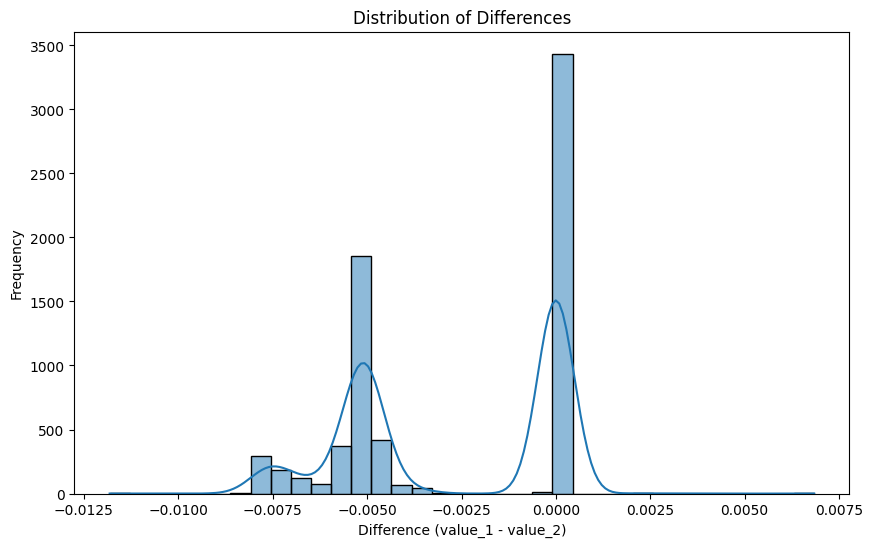

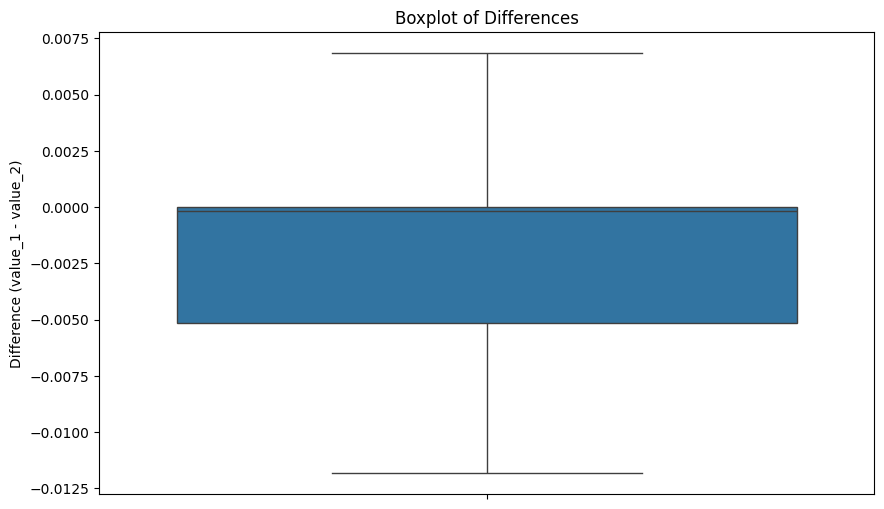

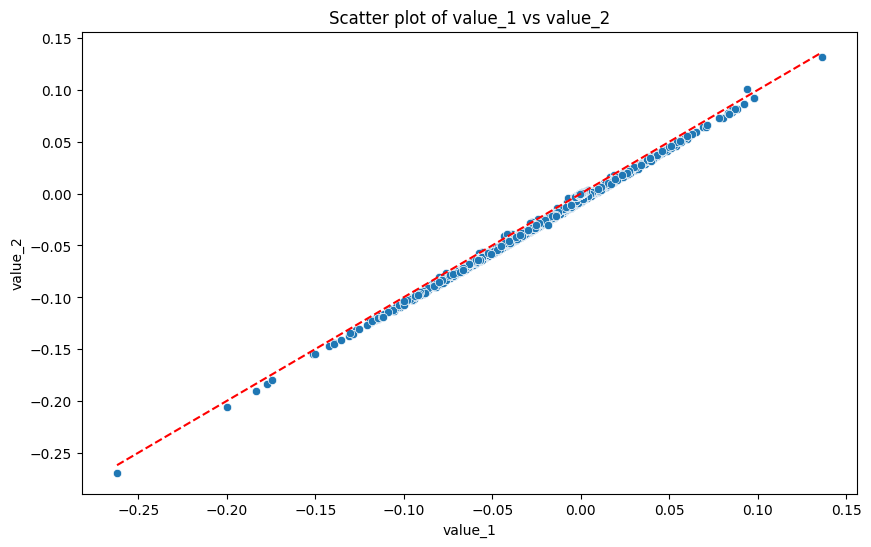

In [271]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of differences
plt.figure(figsize=(10, 6))
sns.histplot(diff['difference'], kde=True)
plt.title('Distribution of Differences')
plt.xlabel('Difference (value_1 - value_2)')
plt.ylabel('Frequency')
plt.show()

# Boxplot of differences
plt.figure(figsize=(10, 6))
sns.boxplot(y=diff['difference'])
plt.title('Boxplot of Differences')
plt.ylabel('Difference (value_1 - value_2)')
plt.show()

# Scatter plot of value_1 vs value_2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=diff['value_1'], y=diff['value_2'])
plt.title('Scatter plot of value_1 vs value_2')
plt.xlabel('value_1')
plt.ylabel('value_2')
plt.plot([diff['value_1'].min(), diff['value_1'].max()], [diff['value_1'].min(), diff['value_1'].max()], 'r--')  # Line of equality
plt.show()


In [272]:
from scipy.stats import ttest_rel

# Perform paired t-test
t_stat, p_value = ttest_rel(diff['value_1'], diff['value_2'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 80.13205987748313
P-value: 0.0


In [495]:
time_coeff_dict = {}
mutated_genes_coeff_dict = {}
for light_regime in light_regimes:
    coef_reg = coeff_dict[light_regime]
    # split the coeff dataframe into three dataframes, one where the name starts with plate, one where the name starts with mutated_genes and one where the name starts with time
    plate_coeff = coef_reg[coef_reg['name'].str.startswith('plate')]
    mutated_genes_coeff_dict[light_regime] = coef_reg[coef_reg['name'].str.startswith('mutated_genes')]
    mutated_genes_coeff_dict[light_regime]['name'] = mutated_genes_coeff_dict[light_regime]['name'].apply(lambda x: x.split('mutated_genes_')[1])
    time_coeff_dict[light_regime] = coef_reg[coef_reg['name'].str.startswith('time:')]
    time_coeff_dict[light_regime]['name'] = time_coeff_dict[light_regime]['name'].apply(lambda x: x.split('time:mutated_genes_')[1])

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_64275/620081577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutated_genes_coeff_dict[light_regime]['name'] = mutated_genes_coeff_dict[light_regime]['name'].apply(lambda x: x.split('mutated_genes_')[1])
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_64275/620081577.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_coeff_dict[light_regime]['name'] = time_coeff_dict[light_regime]['name'].apply(lambda x: x.split('time:mutated

In [346]:
# get the 10 gene with the highest time coefficient
max_time_gene = time_coeff.loc[time_coeff['value'].abs().nlargest(100).index]

In [372]:
# sort the time coeff 
time_coeff_sorted = time_coeff.sort_values(by='value', ascending=True)

In [340]:
max_time_gene['name'].values

array(['time:mutated_genes_Cre02.g147600',
       'time:mutated_genes_Cre02.g095081',
       'time:mutated_genes_Cre17.g736150',
       'time:mutated_genes_Cre17.g733200',
       'time:mutated_genes_Cre05.g235900',
       'time:mutated_genes_Cre12.g521450',
       'time:mutated_genes_Cre14.g613075',
       'time:mutated_genes_Cre16.g656800',
       'time:mutated_genes_Cre16.g672350',
       'time:mutated_genes_Cre06.g285451'], dtype=object)

In [467]:
mutant_data

,mutant_ID,mutated_genes,light_regime,plate,time,y2
25012,LMJ.RY0402.253063,Cre13.g572900,20h_HL,15,1,0.205184
25013,LMJ.RY0402.044351,Cre09.g397327,20h_HL,15,1,0.354204
25014,LMJ.RY0402.043902,Cre17.g709000,20h_HL,15,1,0.263793
25015,LMJ.RY0402.251217,Cre18.g748497,20h_HL,15,1,0.264734
25016,LMJ.RY0402.252845,Cre01.g008200,20h_HL,15,1,0.272787
...,...,...,...,...,...,...
2190491,LMJ.RY0402.045296,Cre17.g739250,20h_HL,15,40,0.218143
2190492,LMJ.RY0402.045118,Cre17.g742200,20h_HL,15,40,0.218387
2190493,LMJ.RY0402.046384,Cre01.g012650,20h_HL,15,40,0.106511
2190494,LMJ.RY0402.045852,Cre01.g038900,20h_HL,15,40,0.300154


In [667]:
time*(time_coeff + mean_time_coeff)

array([0.00024046, 0.00048093, 0.00072139, 0.00096185, 0.00120231,
       0.00144278, 0.00168324, 0.0019237 , 0.00216416, 0.00240463,
       0.00264509, 0.00288555, 0.00312601, 0.00336648, 0.00360694,
       0.0038474 , 0.00408787, 0.00432833, 0.00456879, 0.00480925,
       0.00504972, 0.00529018, 0.00553064, 0.0057711 , 0.00601157,
       0.00625203, 0.00649249, 0.00673295, 0.00697342, 0.00721388,
       0.00745434, 0.00769481, 0.00793527, 0.00817573, 0.00841619,
       0.00865666, 0.00889712, 0.00913758, 0.00937804, 0.00961851])

In [671]:
coeff_dict['20h_HL'][coeff_dict['20h_HL']['name'] == 'time']['value'].values[0]

-0.002240955633352111

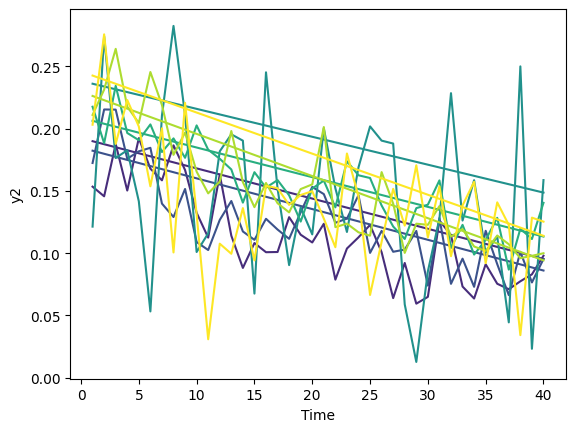

In [684]:
# Get the data of the mutant
mutant_data = df_long[(df_long['plate'] == 15) & (df_long['light_regime'] == '20h_HL')]
mutant_data = data[(data['plate'] == 15) & (data['light_regime'] == '20h_HL')].iloc[18:30]

# Get the time coefficients of the mutant
time_coeff_mutant = time_coeff_dict['20h_HL'][time_coeff_dict['20h_HL']['name'].isin(mutant_data['mutated_genes'].unique())]
mutated_genes_coeff_mutant = mutated_genes_coeff_dict['20h_HL'][mutated_genes_coeff_dict['20h_HL']['name'].isin(mutant_data['mutated_genes'].unique())]

time = np.linspace(1, 40, 40)
intercept = model_dict['20h_HL'].intercept_
mean_time_coeff = coeff_dict['20h_HL'][coeff_dict['20h_HL']['name'] == 'time']['value'].values[0]

colors = plt.cm.viridis(np.linspace(0, 1, len(mutant_data['mutant_ID'].unique())))

# Get the predicted slope for each time point
for i, mutant in enumerate(mutant_data['mutant_ID'].unique()):
    if len(np.unique(mutant_data[mutant_data['mutant_ID'] == mutant]['mutated_genes'].values)) >= 2:
        continue
    gene = mutant_data[mutant_data['mutant_ID'] == mutant]['mutated_genes'].values[0]
    try:
        time_coeff = time_coeff_mutant[time_coeff_mutant['name'] == gene]['value'].values[0]
        gene_coeff = mutated_genes_coeff_mutant[mutated_genes_coeff_mutant['name'] == gene]['value'].values[0]
    except:
        continue
    predicted_slope = time * (time_coeff + mean_time_coeff)
    # y2_values = mutant_data[mutant_data['mutant_ID'] == mutant]['y2'].values
    y2_values = data[(data['plate'] == 15) & (data['light_regime'] == '20h_HL') & (data['mutant_ID'] == mutant)].filter(regex='y2_').dropna(axis=1).values[0]
    plt.plot(time, y2_values, label='y2', color=colors[i])
    plt.plot(time, intercept + predicted_slope + gene_coeff, label='predicted_slope', color=colors[i])

plt.xlabel('Time')
plt.ylabel('y2')
# plt.title(f"Mutant {mutant}")
plt.show()

In [8]:
data_slopes = pd.read_csv('/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/database_phase_1_after_preprocessing_with_right_WT_07_23_2024.csv')

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_16975/1910839675.py:1: DtypeWarning: Columns (381,382) have mixed types. Specify dtype option on import or set low_memory=False.
  data_slopes = pd.read_csv('/Users/samsongourevitch/Documents/Chlamy_Project_Github/Chlamy_project/Data/database_phase_1_after_preprocessing_with_right_WT_07_23_2024.csv')


In [9]:
Data_analysis_func.plot_y2(data_slopes[(data_slopes['mutated_genes'] == time_coef_sorted_filtered['name'].values[18]) & (data_slopes['light_regime'] == '20h_HL')], '20h_HL')

NameError: name 'time_coef_sorted_filtered' is not defined

In [10]:
data_slope_cluster = Outlier_detection_v2.detect_and_cluster_slopes(data_slopes, alpha=0.01)

In [11]:
def custom_sort_key(value):
    desired_order = ['20h_HL', '20h_ML', '2h-2h', '10min-10min', '1min-1min', '30s-30s']
    # desired_order = ['20h_HL', '20h_ML', 'low_2h-2h', 'high_2h-2h', 'low_10min-10min', 'high_10min-10min', 'low_1min-1min', 'high_1min-1min', 'low_30s-30s', 'high_30s-30s']
    # Create a dictionary to map each value to its position in the desired order
    order_map = {value: index for index, value in enumerate(desired_order)}
    return order_map.get(value, len(desired_order))

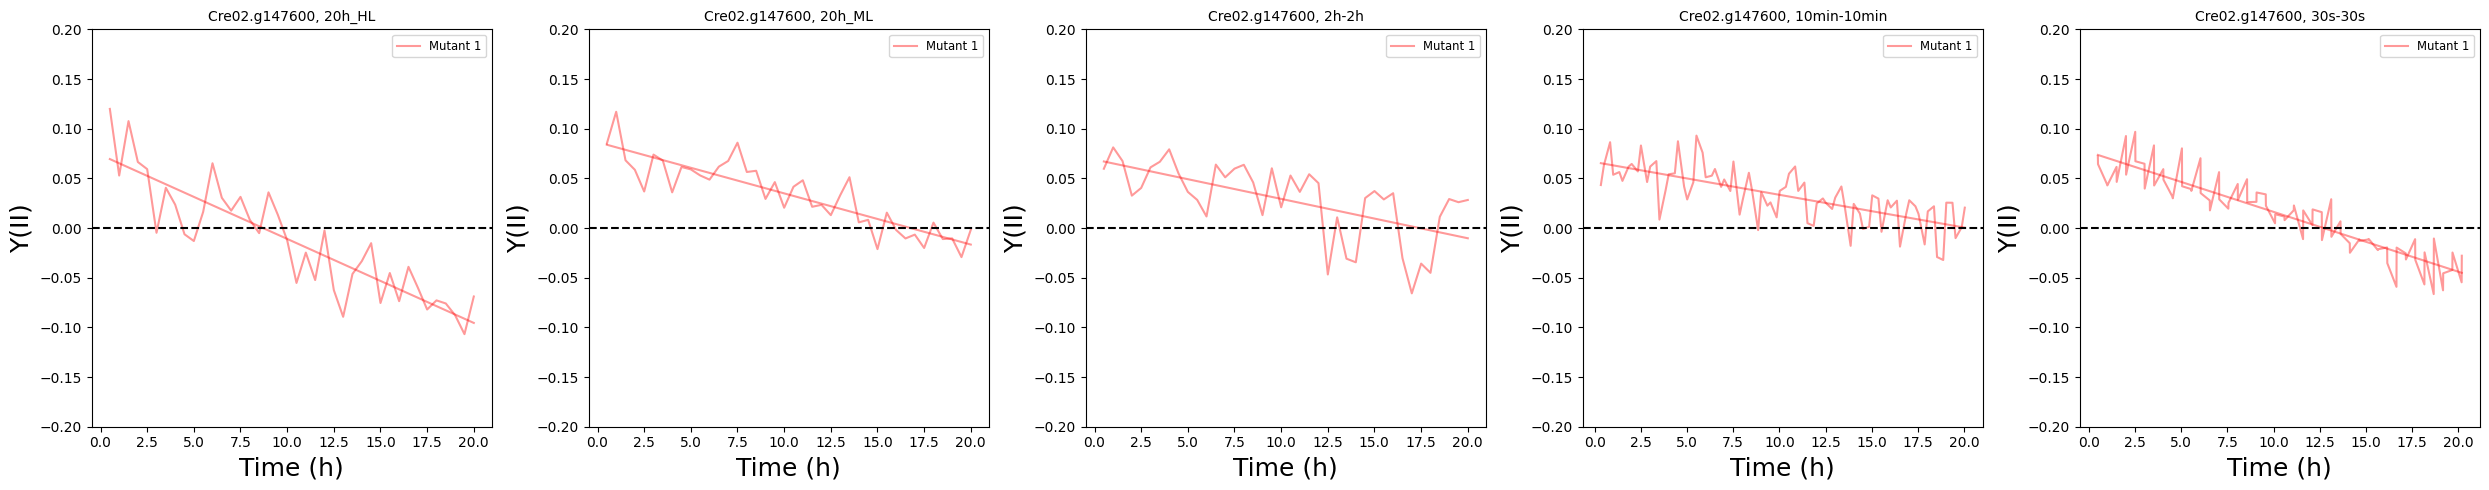

In [533]:
elapsed_time_columns = [col for col in data_slope_cluster.columns if 'elapsed_time' in col]
already_seen_genes = []

y = 'y2'

for i in range(1):
# # for i in range(10):
    gene_of_interest = time_coef_sorted_filtered['name'].values[10]
    gene_of_interest = 'Cre02.g147600'
    # mutant_of_interest = region_mutants_RTL['mutant_ID'].unique()[i]
#     # mutant_of_interest = result_residuals_slope['mutant_ID'].unique()[i+50]
#     # mutant_of_interest = mutant_data_with_pca.sort_values(by='slope_y2_1min-1min')['mutant_ID'].unique()[i]
#     mutant_of_interest = final_filtered_mutants.sort_values(by='slope_y2')['mutant_ID'].unique()[i]
#     # mutant_of_interest = final_filtered_mutants.sort_values(by='confidence')['mutant_ID'].unique()[i]
#     # mutant_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutant_ID'].unique()[i]

#     try:
#         gene_of_interest = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest)]['mutated_genes'].unique()[0]
#     except:
#         print('mutant_of_interest : ', mutant_of_interest)
    # # gene_of_interest = gene_diff[i]
    # if gene_of_interest in already_seen_genes or gene_of_interest == 'special_mutant':
    #     continue
    # if mutant_of_interest in already_seen_genes or mutant_of_interest == 'WT':
    #     continue
    already_seen_genes.append(gene_of_interest)
    # already_seen_genes.append(mutant_of_interest)
    # gene_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutated_genes'].unique()[i]

    # Sample array containing some of the values
    # light_regimes = data_slopes[(data_slopes['mutant_ID'] == mutant_of_interest)]['light_regime'].unique()
    light_regimes = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest)]['light_regime'].unique()

    # Sort the array using the custom sort key
    sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)
    # titles = ['Y(II) for gene ' + str(gene_of_interest) + ' in ' + light for light in sorted_light_regimes]
    titles = [str(gene_of_interest) + ', ' + light for light in sorted_light_regimes]
    # titles = ['Y(II) for gene ' + str(mutant_of_interest) + ' in ' + light for light in sorted_light_regimes]
    # colors = ['b', 'r', 'g', 'k', 'purple', 'grey']
    # colors = colors[:len(titles)]

    # Prepare subplot layout
    fig, axes = plt.subplots(1, len(titles), figsize=(25, 5))

    # Iterate over light regimes and plot Y(II) values
    for j, (light_regime, title) in enumerate(zip(sorted_light_regimes, titles)):
        # Filter data for the current gene and light regime
        # filtered_data = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest) & 
        #                                     (data_slope_cluster['light_regime'] == light_regime)]
        filtered_data = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest) & 
                                            (data_slope_cluster['light_regime'] == light_regime)]
        
        # print('light_regime :' , light_regime, 'fv_fm : ', filtered_data['fv_fm'].values)
        # Extract Y(II) values and plot each line
        y2_values = filtered_data.filter(regex=r'^'+y+'_\d+$').dropna(axis=1).values

        for k in range(y2_values.shape[0]):
            if light_regime in ['high_2h-2h', 'high_10min-10min', 'high_1min-1min', 'high_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:]
            elif light_regime in ['low_2h-2h', 'low_10min-10min', 'low_1min-1min', 'low_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][:-1]
            else:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:-1]
            if filtered_data['slope_cluster_' + y].values[k] != 0:
                color = 'r'
            else:
                color = 'b'
            # color = 'b'
            try :
                axes[j].plot(elapsed_time, y2_values[k], c=color, alpha=0.4, label='Mutant {}'.format(k+1))
                # plot the linear regression
                model = LinearRegression()
                model.fit(elapsed_time.reshape(-1, 1), y2_values[k])
                y_pred = model.predict(elapsed_time.reshape(-1, 1))
                axes[j].plot(elapsed_time, y_pred, c='r', alpha=0.4)
                axes[j].axhline(y=0, color='black', linestyle='--')
                # Set title and other plot properties
                axes[j].set_title(title, fontsize=10)
                # axes[j].set_title(light_regime)
                axes[j].set_xlabel('Time (h)', fontsize=18)
                axes[j].set_ylabel('Y(II)', fontsize=18)
                axes[j].set_ylim(-0.2, 0.2)
                axes[j].legend(loc='upper right', fontsize='small')
            except:
                continue

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

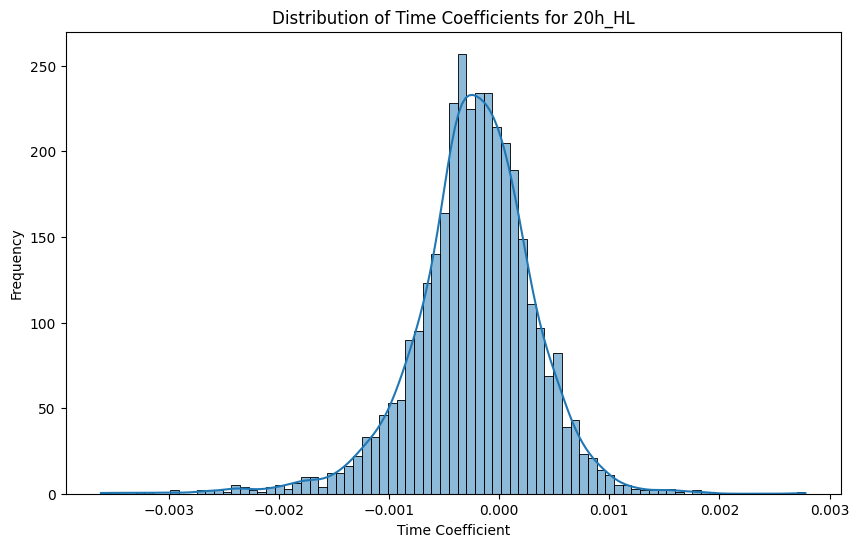

In [369]:
# plot a hist of the time coefficient and overlay a normal distribution
plt.figure(figsize=(10, 6))
sns.histplot(time_coeff['value'], kde=True)

# Calculate the mean and standard deviation of the time coefficients
mean_time_coeff = time_coeff['value'].mean()
std_time_coeff = time_coeff['value'].std()

plt.title('Distribution of Time Coefficients for 20h_HL')
plt.xlabel('Time Coefficient')
plt.ylabel('Frequency')
plt.show()

In [513]:
time_coeff_dict['20h_HL']

,name,value
3458,Cre01.g000100,-0.000541
3459,Cre01.g000250,-0.000434
3460,Cre01.g000650,-0.000736
3461,Cre01.g001150,-0.000099
3462,Cre01.g001200,-0.000313
...,...,...
6887,Cre35.g759247,0.000544
6888,Cre36.g759697,0.000402
6889,Cre49.g761297,-0.000874
6890,special_mutant,0.000085


In [12]:
gene_data = Data_v2.get_gene_data_y2(data_slopes)

In [770]:
gene_data

,light_regime,mutated_genes,fv_fm,fv_fm_end,y2_1,y2_2,y2_3,y2_4,y2_5,y2_6,y2_7,y2_8,y2_9,y2_10,y2_11,y2_12,y2_13,y2_14,y2_15,y2_16,y2_17,y2_18,y2_19,y2_20,y2_21,y2_22,y2_23,y2_24,y2_25,y2_26,y2_27,y2_28,y2_29,y2_30,y2_31,y2_32,y2_33,y2_34,y2_35,y2_36,y2_37,y2_38,y2_39,y2_40,y2_41,y2_42,y2_43,y2_44,y2_45,y2_46,y2_47,y2_48,y2_49,y2_50,y2_51,y2_52,y2_53,y2_54,y2_55,y2_56,y2_57,y2_58,y2_59,y2_60,y2_61,y2_62,y2_63,y2_64,y2_65,y2_66,y2_67,y2_68,y2_69,y2_70,y2_71,y2_72,y2_73,y2_74,y2_75,y2_76,y2_77,y2_78,y2_79,y2_80,y2_81,y2_82,y2_83,y2_84,y2_85,y2_86,y2_87,y2_88,mean_y2,mean_y2_std,slope_y2,slope_y2_std
0,10min-10min,Cre01.g000100,-0.020006,-0.024656,-0.013880,-0.026737,-0.024579,-0.024881,-0.024915,-0.021586,-0.014930,-0.032813,-0.046664,-0.037699,-0.025307,-0.025156,-0.026249,-0.022851,-0.019204,-0.027642,-0.036548,-0.026839,-0.019988,-0.034761,-0.030637,-0.030939,-0.023835,-0.034472,-0.020750,-0.015827,-0.045053,-0.026106,-0.043141,-0.032613,-0.025455,-0.038817,-0.025782,-0.005726,-0.032229,-0.047102,-0.024905,-0.047603,-0.018762,-0.028915,-0.035190,-0.020923,-0.014446,-0.031355,-0.031185,-0.011554,-0.019376,-0.032181,-0.034270,-0.017345,-0.018163,-0.027413,-0.036473,-0.030398,-0.011738,-0.028453,-0.024817,-0.034672,-0.013128,-0.029823,-0.027201,-0.018709,-0.030393,-0.048904,-0.037268,-0.024012,-0.034736,-0.025884,-0.035715,-0.021476,-0.009922,-0.041284,-0.034162,0.001751,-0.042437,-0.036915,-0.036349,-0.020101,-0.017389,-0.033297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027615,NaN,-0.000040,NaN
1,10min-10min,Cre01.g000250,-0.013695,-0.015859,-0.008439,-0.011555,-0.049059,-0.015735,-0.022201,-0.030100,-0.053754,-0.021957,-0.012378,-0.049688,-0.014998,-0.011829,-0.020935,-0.049286,-0.039824,-0.012853,-0.005402,-0.039425,-0.027310,-0.015031,-0.003334,-0.053517,-0.010138,-0.011444,-0.009278,-0.027919,-0.023402,-0.012494,-0.015926,-0.047966,-0.056882,-0.008793,-0.026649,-0.038400,-0.045440,-0.025248,-0.019115,-0.074285,-0.030474,-0.020044,-0.023925,-0.035283,-0.034534,-0.007044,-0.013737,-0.047118,-0.051554,-0.021297,-0.025835,-0.050225,-0.039528,-0.017144,-0.017591,-0.024038,-0.041384,-0.017718,-0.001907,-0.041093,0.007235,-0.013998,-0.026815,-0.033248,-0.042107,-0.021916,-0.012680,-0.055711,-0.042998,-0.017602,-0.027980,-0.051386,-0.036643,-0.010504,-0.011254,-0.042820,-0.034853,-0.020006,-0.019667,-0.036470,-0.038256,-0.007196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.027254,NaN,-0.000167,NaN
2,10min-10min,Cre01.g000650,-0.016833,-0.017694,-0.026648,-0.005484,-0.004472,-0.021850,-0.014636,0.004962,-0.012278,-0.023031,-0.019362,-0.028325,-0.020255,-0.029669,-0.020211,-0.024777,-0.012810,-0.025609,-0.013213,0.007737,0.000821,-0.016813,-0.015234,0.000634,-0.012846,-0.014272,-0.025377,-0.038306,-0.002783,-0.019158,-0.014051,-0.007184,0.015945,-0.016398,-0.005079,-0.023081,-0.046209,-0.021896,-0.016424,-0.051679,-0.018020,-0.022011,-0.023456,-0.034164,-0.050807,-0.014263,-0.029951,-0.045982,-0.008897,-0.016824,-0.033788,-0.055462,-0.002616,-0.018472,-0.020583,-0.029063,-0.030746,-0.032307,-0.024217,-0.026874,0.000993,-0.017801,-0.012696,-0.043889,-0.039886,-0.022190,-0.010491,-0.037670,-0.036652,-0.027501,-0.023862,-0.038207,-0.024770,-0.026807,-0.031447,-0.013675,-0.010643,-0.005814,-0.007526,0.006257,-0.030457,-0.012120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.020309,0.063184,-0.000479,0.000411
3,10min-10min,Cre01.g001150,-0.040445,-0.037692,-0.036412,-0.004086,-0.024503,-0.035513,-0.042426,-0.029893,-0.025517,-0.034870,-0.031300,-0.040719,-0.020239,-0.027539,-0.040368,-0.035199,-0.021149,-0.027788,-0.039135,-0.033229,-0.005013,-0.037952,-0.036323,-0.016129,-0.041465,-0.048313,-0.042439,-0.039115,-0.034938,-0.038924,-0.041851,-0.035530,-0.021893,-0.037545,-0.043141,-0.038623,-0.036944,-0.036681,-0.044983,-0.046391,-0.024419,-0.033398,-0.039465,-0.015886,-0.032029,-0.047501,-0.031905,-0.025991,-0.022056,-0.049825,-0.044532,-0.036429,-0.037593,-0.041360,-0.035659,-0.010034,-0.048493,-0.046221,-0.036049,-0.038723,-0.011671,-0.032190,-0.047826,-0.041247,-0

In [13]:
gene_pivot = Data_v2.get_pivot_features_genes(gene_data)

In [787]:
gene_pivot

,mutated_genes,mean_y2_10min-10min,mean_y2_1min-1min,mean_y2_20h_HL,mean_y2_20h_ML,mean_y2_2h-2h,mean_y2_30s-30s,mean_y2_std_10min-10min,mean_y2_std_1min-1min,mean_y2_std_20h_HL,mean_y2_std_20h_ML,mean_y2_std_2h-2h,mean_y2_std_30s-30s,slope_y2_10min-10min,slope_y2_1min-1min,slope_y2_20h_HL,slope_y2_20h_ML,slope_y2_2h-2h,slope_y2_30s-30s,slope_y2_std_10min-10min,slope_y2_std_1min-1min,slope_y2_std_20h_HL,slope_y2_std_20h_ML,slope_y2_std_2h-2h,slope_y2_std_30s-30s
0,Cre01.g000100,-0.027615,-0.046244,-0.025064,-0.029398,-0.049201,-0.053546,NaN,0.033690,0.004105,0.001856,NaN,0.006643,-0.000040,-0.000529,-0.000710,-0.000884,0.000240,-0.000453,NaN,0.000218,0.000425,0.000625,NaN,0.000340
6,Cre01.g000250,-0.027254,-0.020792,-0.031269,-0.049805,-0.022370,-0.026622,NaN,NaN,NaN,NaN,NaN,NaN,-0.000167,0.000769,0.000024,0.000983,0.001344,0.001216,NaN,NaN,NaN,NaN,NaN,NaN
12,Cre01.g000650,-0.020309,-0.001060,-0.060552,-0.034221,-0.022168,0.004202,0.063184,0.023561,0.018223,0.072200,0.040850,0.083641,-0.000479,-0.001824,-0.001650,-0.000825,-0.000347,-0.000362,0.000411,0.000639,0.001647,0.000048,0.001234,0.001520
18,Cre01.g001150,-0.034952,-0.025659,-0.033150,-0.032572,-0.026621,-0.017049,0.001768,0.005843,NaN,0.003669,0.001303,0.007726,-0.000450,0.000440,-0.000432,-0.000516,-0.000076,-0.000388,0.000086,0.000190,NaN,0.000088,0.000784,0.000204
24,Cre01.g001200,-0.033802,-0.015840,-0.046019,-0.057194,-0.006714,-0.020555,NaN,NaN,NaN,NaN,NaN,NaN,0.000006,-0.000288,-0.001191,0.000286,0.001416,-0.000007,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21538,WT_97,0.062331,0.048147,0.043440,0.046219,0.039968,0.054149,0.008924,0.023748,0.014043,0.026580,0.015981,0.031751,-0.000331,0.000700,-0.000966,0.000773,0.000103,0.000344,0.001268,0.001282,0.001593,0.001847,0.001099,0.002401
21544,WT_98,0.008471,0.006505,0.007878,0.015150,0.003780,0.000453,0.004907,0.009662,0.009131,0.009721,0.006313,0.005312,-0.000072,-0.000061,-0.000207,0.000007,-0.000211,-0.000114,0.000240,0.000242,0.000345,0.000216,0.000247,0.000532
21550,WT_99,0.001969,0.013662,0.005819,0.006405,0.000950,0.000371,0.010570,0.008794,0.007833,0.013851,0.007886,0.010107,-0.000246,-0.000294,-0.000100,0.000304,-0.000256,-0.000258,0.000349,0.000212,0.000158,0.000476,0.000224,0.000450
21556,special_mutant,0.029137,0.056061,0.072132,0.065674,0.033284,0.039157,0.067734,0.083518,0.098536,0.093680,0.058936,0.089617,-0.000404,-0.000107,0.000967,0.001181,-0.000088,-0.000188,0.001672,0.002222,0.003421,0.001812,0.001656,0.002228


In [644]:
gene_data_HL = gene_data[gene_data['light_regime'] == '20h_HL']

In [521]:
# merge gene_data_HL and time_coeff_dict['20h_HL'] on the key 'mutated_genes' and 'name'
slope_1_2 = gene_data_HL.merge(time_coeff_dict['20h_HL'], left_on='mutated_genes', right_on='name')

In [524]:
# compute the correlation between the time coefficient and the slope
slope_1_2['value'].corr(slope_1_2['slope_y2'])

0.7548731965735336

In [528]:
# get the genes that have a very different time coefficient and slope
slope_1_2['difference'] = np.abs(slope_1_2['value'] - slope_1_2['slope_y2'])

In [529]:
# get the genes with the bigest difference
slope_1_2_sorted = slope_1_2.sort_values(by='difference', ascending=False)

In [531]:
slope_1_2_sorted = slope_1_2_sorted[['mutated_genes', 'value', 'slope_y2', 'difference']]

In [532]:
slope_1_2_sorted 

,mutated_genes,value,slope_y2,difference
545,Cre02.g147600,-0.003618,-0.008454,4.836133e-03
316,Cre02.g086550,-0.000477,-0.004113,3.636350e-03
1242,Cre06.g285451,-0.002667,-0.006071,3.404894e-03
3010,Cre16.g656800,-0.002718,-0.006034,3.316285e-03
1276,Cre06.g295050,-0.001886,-0.004968,3.081967e-03
...,...,...,...,...
2614,Cre13.g568550,0.000179,0.000180,1.218296e-06
1780,Cre09.g396200,-0.000115,-0.000116,1.034806e-06
1437,Cre07.g328150,-0.000572,-0.000571,1.032560e-06
1185,Cre06.g278165,0.000702,0.000702,5.327374e-07


In [386]:
data_HL = data[data['light_regime'] == '20h_HL']

In [423]:
# add the column mutated_genes_light_regime_count to time_coeff_sorted based on the key mutated_genes
time_coeff_sorted['count'] = time_coeff_sorted['name'].apply(lambda x: data_HL[data_HL['mutated_genes'] == x].shape[0])

In [424]:
time_coef_sorted_filtered = time_coeff_sorted[time_coeff_sorted['count'] >= 2]

In [427]:
time_coef_sorted_filtered

,name,value,count
3829,Cre02.g095081,-0.003471,2
6533,Cre16.g672350,-0.002687,2
4700,Cre06.g285451,-0.002667,2
4861,Cre07.g323450,-0.002436,2
4718,Cre06.g291850,-0.002373,2
...,...,...,...
3487,Cre01.g007300,0.001196,2
5376,Cre10.g421550,0.001202,2
3837,Cre02.g095116,0.001644,2
4036,Cre03.g152200,0.001798,2


In [428]:
prev_mutant = pd.read_csv('third_list_final_mutants_for_screen_07_16_2024.csv')

In [431]:
prev_genes_20h_HL = prev_mutant[prev_mutant['source_df'] == '20h_HL']['mutated_genes'].values

In [434]:
len(prev_genes_20h_HL)

93

In [509]:
len(np.intersect1d(prev_genes_20h_HL, time_coef_sorted_filtered['name'].values[:100]))

16

In [406]:
# get the intersection of every genes in the different light regimes of time_coef_dict
intersection = []
for gene in time_coef_sorted_filtered['name']:
    if all([gene in time_coeff_dict[light_regime]['name'].values for light_regime in light_regimes]):
        intersection.append(gene)

2410

In [407]:
# only keep the genes that are in all the light regimes and concatenate the time_coeff_dict
time_coeff_dict_filtered = {}
for light_regime in light_regimes:
    time_coeff_dict_filtered[light_regime] = time_coeff_dict[light_regime][time_coeff_dict[light_regime]['name'].isin(intersection)]

In [582]:
# Step 1: Add a column for the light_regime in each DataFrame
for light_regime, df in time_coeff_dict.items():
    df['light_regime'] = light_regime

# Step 2: Concatenate all DataFrames into one
combined_df = pd.concat(time_coeff_dict.values())

# Step 3: Pivot the combined DataFrame
result_df = combined_df.pivot(index='name', columns='light_regime', values='value').reset_index()

# Optionally, rename columns to include a prefix or suffix for clarity
result_df.columns.name = None  # Remove the columns name (previously 'light_regime')
result_df.columns = ['name'] + [f'{col}_value' for col in result_df.columns[1:]]

/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_64275/3853785816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['light_regime'] = light_regime
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_64275/3853785816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['light_regime'] = light_regime
/var/folders/1m/j6l58hd9755c0h_89l4yckhw0000gn/T/ipykernel_64275/3853785816.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

In [583]:
result_df

,name,10min-10min_value,1min-1min_value,20h_HL_value,20h_ML_value,2h-2h_value,30s-30s_value
0,Cre01.g000100,-0.000009,-0.000071,-0.000541,-0.000251,-0.000261,0.000095
1,Cre01.g000250,-0.000313,0.000023,-0.000434,0.000021,-0.000629,0.000379
2,Cre01.g000650,-0.000263,-0.000400,-0.000736,-0.000210,-0.000771,0.000054
3,Cre01.g001150,-0.000219,0.000200,-0.000099,-0.000182,-0.000378,0.000388
4,Cre01.g001200,-0.000191,0.000153,-0.000313,-0.000014,-0.000318,0.000348
...,...,...,...,...,...,...,...
3480,Cre35.g759247,-0.000432,-0.000225,0.000544,0.000755,-0.000417,0.000330
3481,Cre36.g759697,-0.000214,-0.000011,0.000402,-0.000394,-0.000388,0.000270
3482,Cre49.g761297,-0.000191,-0.000094,-0.000874,-0.000503,-0.000389,-0.000026
3483,special_mutant,-0.000006,-0.000092,0.000085,0.000532,-0.000324,0.000314


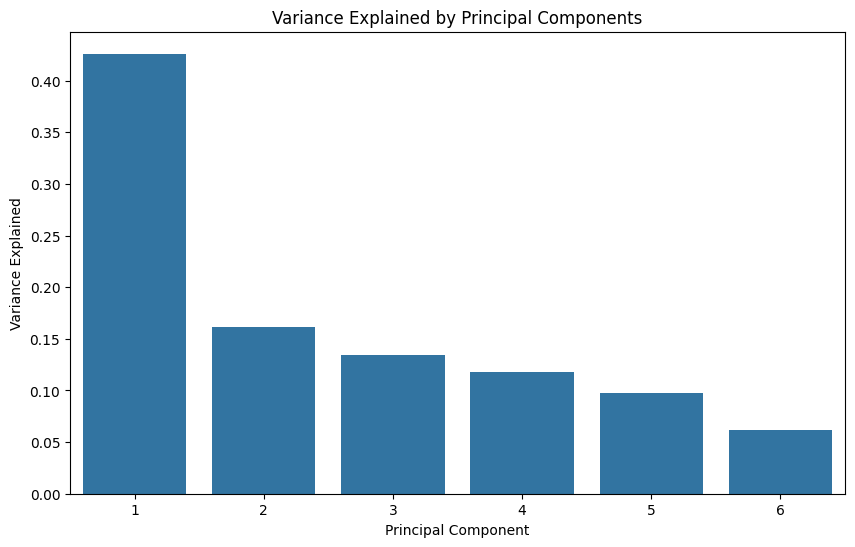

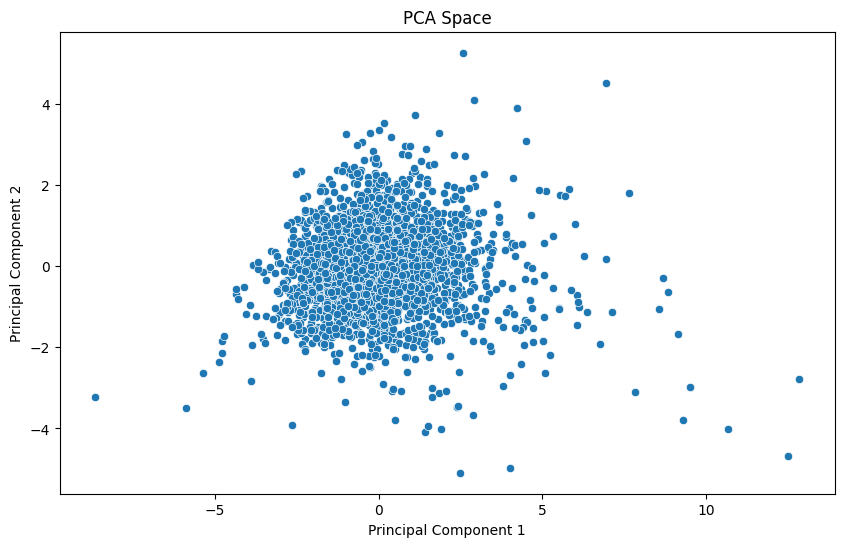

In [585]:
# do a pca on the result_df values
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract the values
X = result_df.dropna().drop(columns='name').values

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_standardized)

# get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=result_df.drop(columns='name').columns, columns=[f'PC{i+1}' for i in range(pca.n_components)])

# plot the variance explained by the different components
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, pca.n_components + 1), y=pca.explained_variance_ratio_)
plt.title('Variance Explained by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# plot the PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1])
plt.title('PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



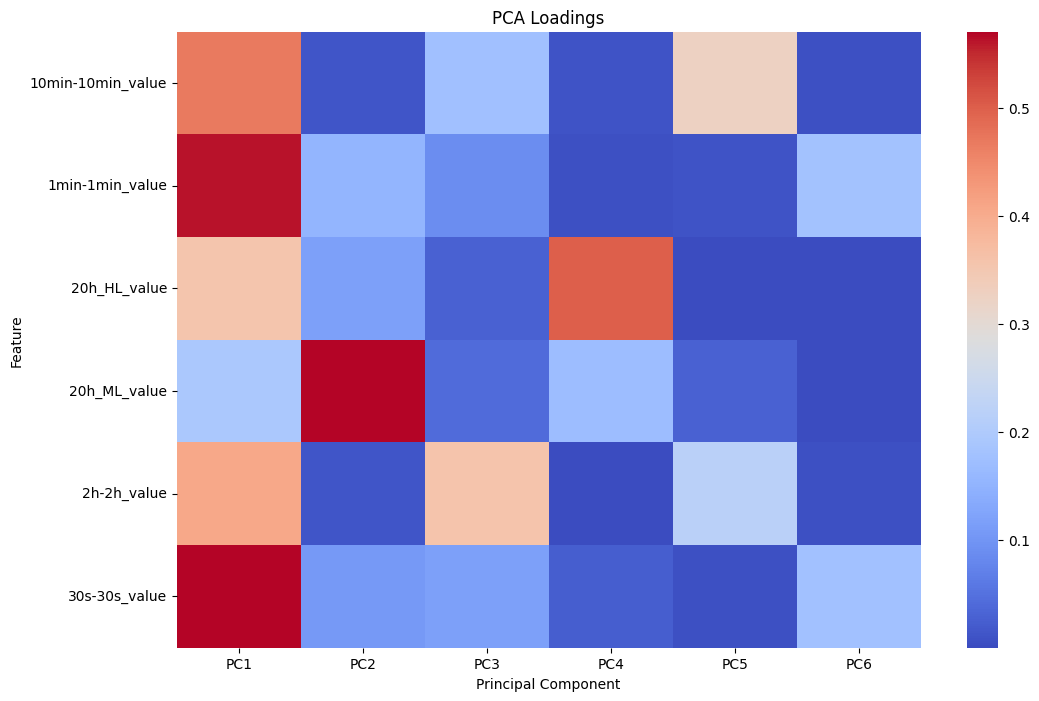

In [586]:
# plot the loadings 
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df**2, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('PCA Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.show()

In [598]:
# read the .txt file containing the gene names
interesting_gene_dict = {}
types = ['high_light_sensitive_frequency_independant', 'high_light_high_frequency_sensitivity', 'high_frequency_sensitivity', 'high_light']
for type in types:
    file_path = type + '.txt'
    try:
        with open(file_path, 'r') as file:
            contents = file.read()
            if contents:
                interesting_genes = contents.splitlines()
            else:
                print("File is empty.")
    except Exception as e:
        print(f"An error occurred: {e}")
    interesting_gene_dict[type] = interesting_genes

In [599]:
result_df.rename(columns={'name': 'mutated_genes'}, inplace=True)

In [772]:
# add a column to result_df that indicates for which type of gene the gene is
result_df['gene_type'] = 'other'
gene_pivot['gene_type'] = 'other'
for type, genes in interesting_gene_dict.items():
    result_df.loc[result_df['mutated_genes'].isin(genes), 'gene_type'] = type
    gene_pivot.loc[gene_pivot['mutated_genes'].isin(genes), 'gene_type'] = type

# if the gene starts with WT the type is WT
result_df.loc[result_df['mutated_genes'].str.startswith('WT'), 'gene_type'] = 'WT'
gene_pivot.loc[gene_pivot['mutated_genes'].str.startswith('WT'), 'gene_type'] = 'WT'

In [615]:
result_df

,mutated_genes,10min-10min_value,1min-1min_value,20h_HL_value,20h_ML_value,2h-2h_value,30s-30s_value,gene_type
0,Cre01.g000100,-0.000009,-0.000071,-0.000541,-0.000251,-0.000261,0.000095,other
1,Cre01.g000250,-0.000313,0.000023,-0.000434,0.000021,-0.000629,0.000379,other
2,Cre01.g000650,-0.000263,-0.000400,-0.000736,-0.000210,-0.000771,0.000054,other
3,Cre01.g001150,-0.000219,0.000200,-0.000099,-0.000182,-0.000378,0.000388,other
4,Cre01.g001200,-0.000191,0.000153,-0.000313,-0.000014,-0.000318,0.000348,other
...,...,...,...,...,...,...,...,...
3480,Cre35.g759247,-0.000432,-0.000225,0.000544,0.000755,-0.000417,0.000330,other
3481,Cre36.g759697,-0.000214,-0.000011,0.000402,-0.000394,-0.000388,0.000270,other
3482,Cre49.g761297,-0.000191,-0.000094,-0.000874,-0.000503,-0.000389,-0.000026,other
3483,special_mutant,-0.000006,-0.000092,0.000085,0.000532,-0.000324,0.000314,other


In [616]:
result_df[result_df['mutated_genes'].isin(interesting_gene_dict['high_light_high_frequency_sensitivity'])]

,mutated_genes,10min-10min_value,1min-1min_value,20h_HL_value,20h_ML_value,2h-2h_value,30s-30s_value,gene_type
102,Cre01.g019500,-2.475246e-04,-0.000332,-0.000939,-0.000670,-0.000773,-0.000191,high_light_high_frequency_sensitivity
103,Cre01.g019550,-2.734365e-04,-0.000344,-0.000324,0.000100,-0.001078,-0.000071,high_light_high_frequency_sensitivity
298,Cre02.g080750,-2.334079e-04,-0.000190,-0.000578,-0.000503,-0.000828,0.000085,high_light_high_frequency_sensitivity
346,Cre02.g092500,-7.914249e-07,-0.000262,-0.001646,0.000079,-0.000606,0.000097,high_light_high_frequency_sensitivity
380,Cre02.g095115,-4.384743e-04,-0.000042,-0.000096,0.000069,-0.000696,-0.000622,high_light_high_frequency_sensitivity
...,...,...,...,...,...,...,...,...
2973,Cre15.g635800,-7.087288e-04,-0.000386,-0.000764,-0.000217,-0.001221,-0.000365,high_light_high_frequency_sensitivity
3034,Cre16.g654150,-1.930078e-04,-0.000015,-0.000011,0.000037,-0.000421,-0.000060,high_light_high_frequency_sensitivity
3102,Cre16.g667900,-4.588385e-04,-0.000694,-0.000859,-0.000242,-0.000453,-0.000171,high_light_high_frequency_sensitivity
3295,Cre17.g710300,-5.970297e-04,-0.000431,-0.001487,-0.000325,-0.000864,-0.000228,high_light_high_frequency_sensitivity


In [773]:
gene_pivot['gene_type'].value_counts()

gene_type
other                                         3378
WT                                             256
high_frequency_sensitivity                      48
high_light_high_frequency_sensitivity           24
high_light                                      22
high_light_sensitive_frequency_independant      13
Name: count, dtype: int64

In [53]:
feature_slope_columns = [col for col in gene_pivot.columns if 'slope' in col]

Accuracy: 0.75


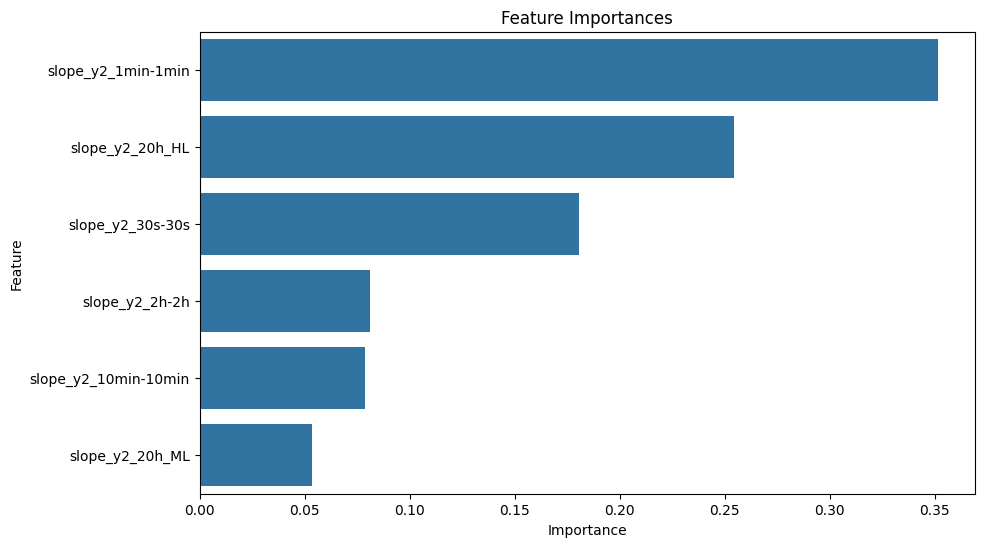

In [783]:
# train a model to predict the gene type

gene_df_filtered = gene_pivot[gene_pivot['gene_type'] != 'other']

# Define the features and target
X = gene_df_filtered[feature_slope_columns]
y = gene_df_filtered['gene_type']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0)

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

# Get feature importances
importances = model.feature_importances_
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Accuracy: 0.2727272727272727


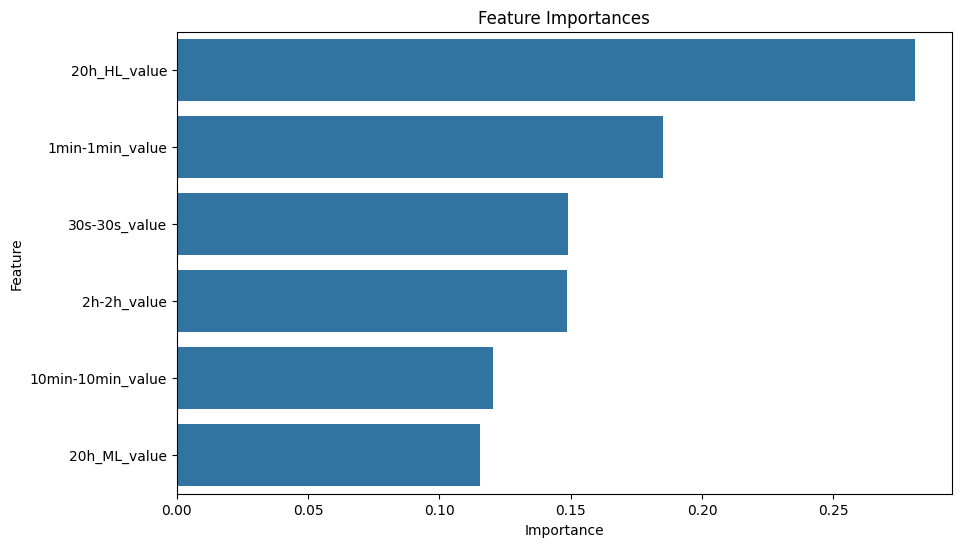

In [782]:
# train a model to predict the gene type

result_df_filtered = result_df[result_df['gene_type'] != 'other']

# Define the features and target
X = result_df_filtered.drop(columns=['mutated_genes', 'gene_type'])
y = result_df_filtered['gene_type']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Evaluate the model
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

# Get feature importances
importances = model.feature_importances_
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

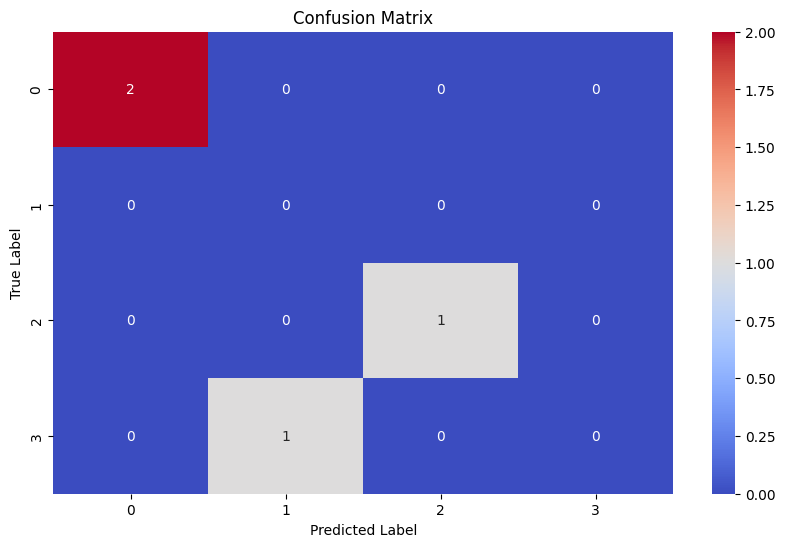

In [784]:
from sklearn.metrics import confusion_matrix

# plot the confusion matrix
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [578]:
result_df.drop(columns='predicted_gene_type', inplace=True)

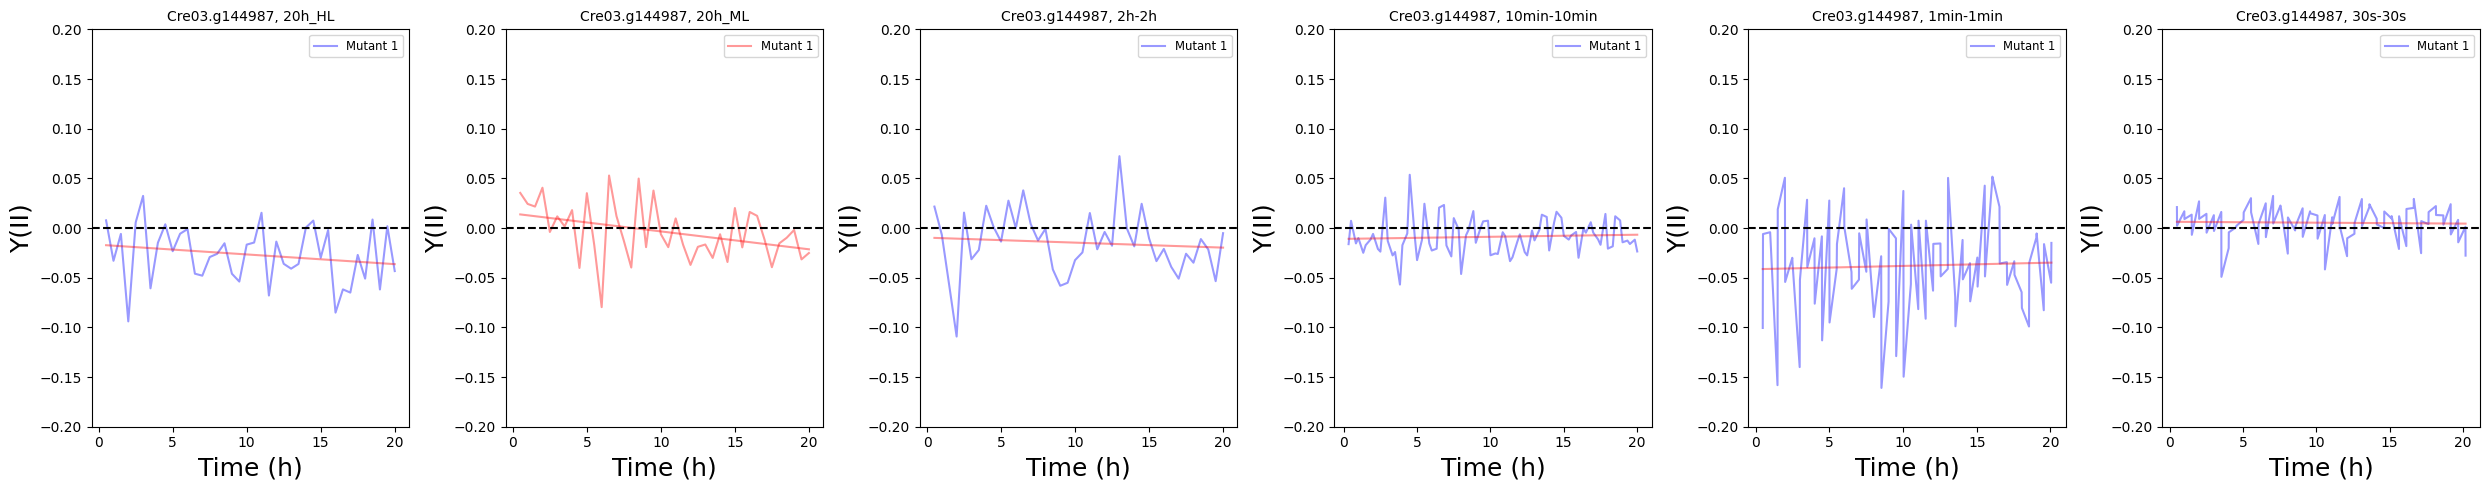

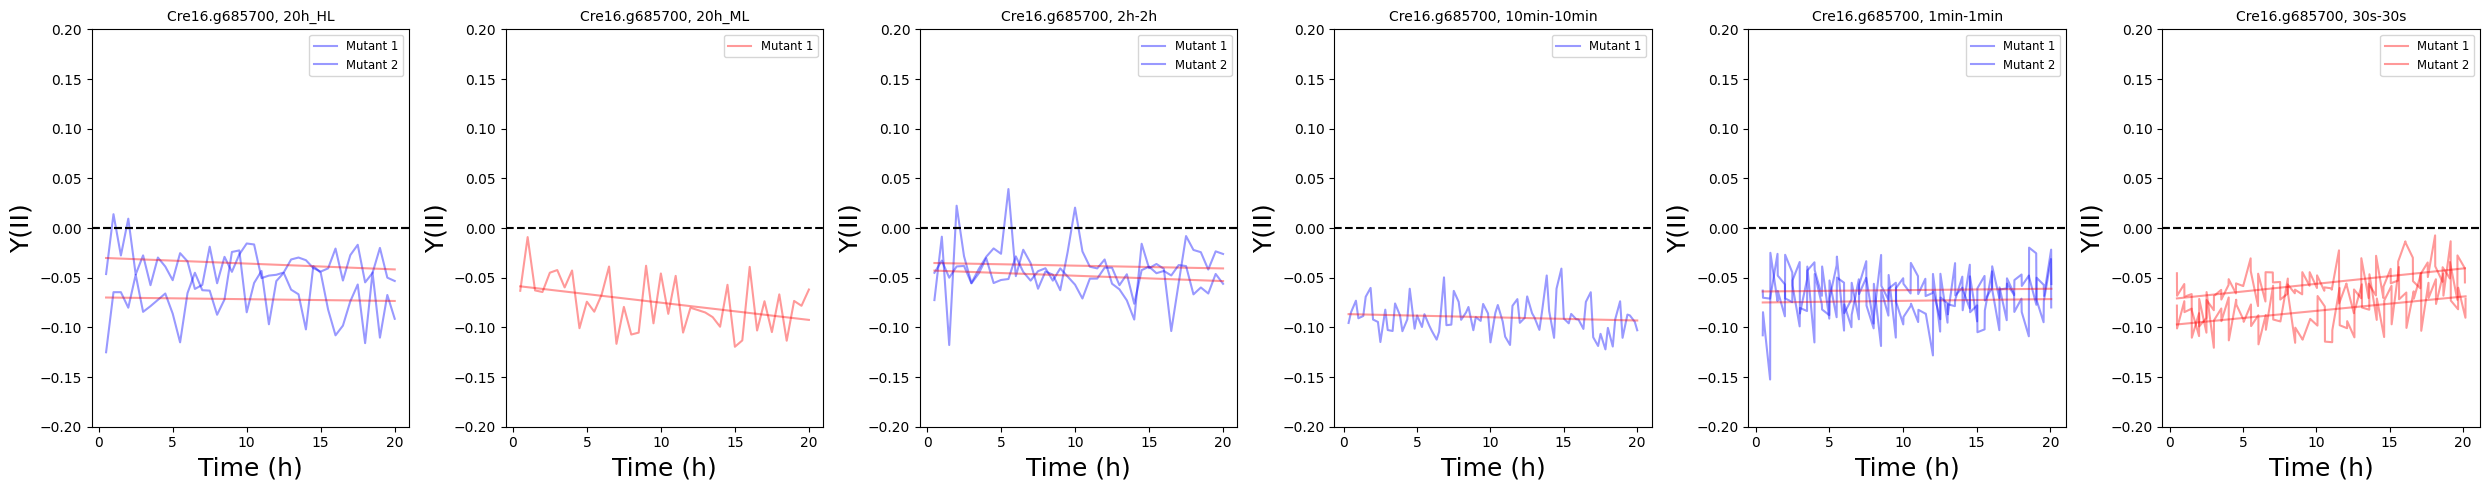

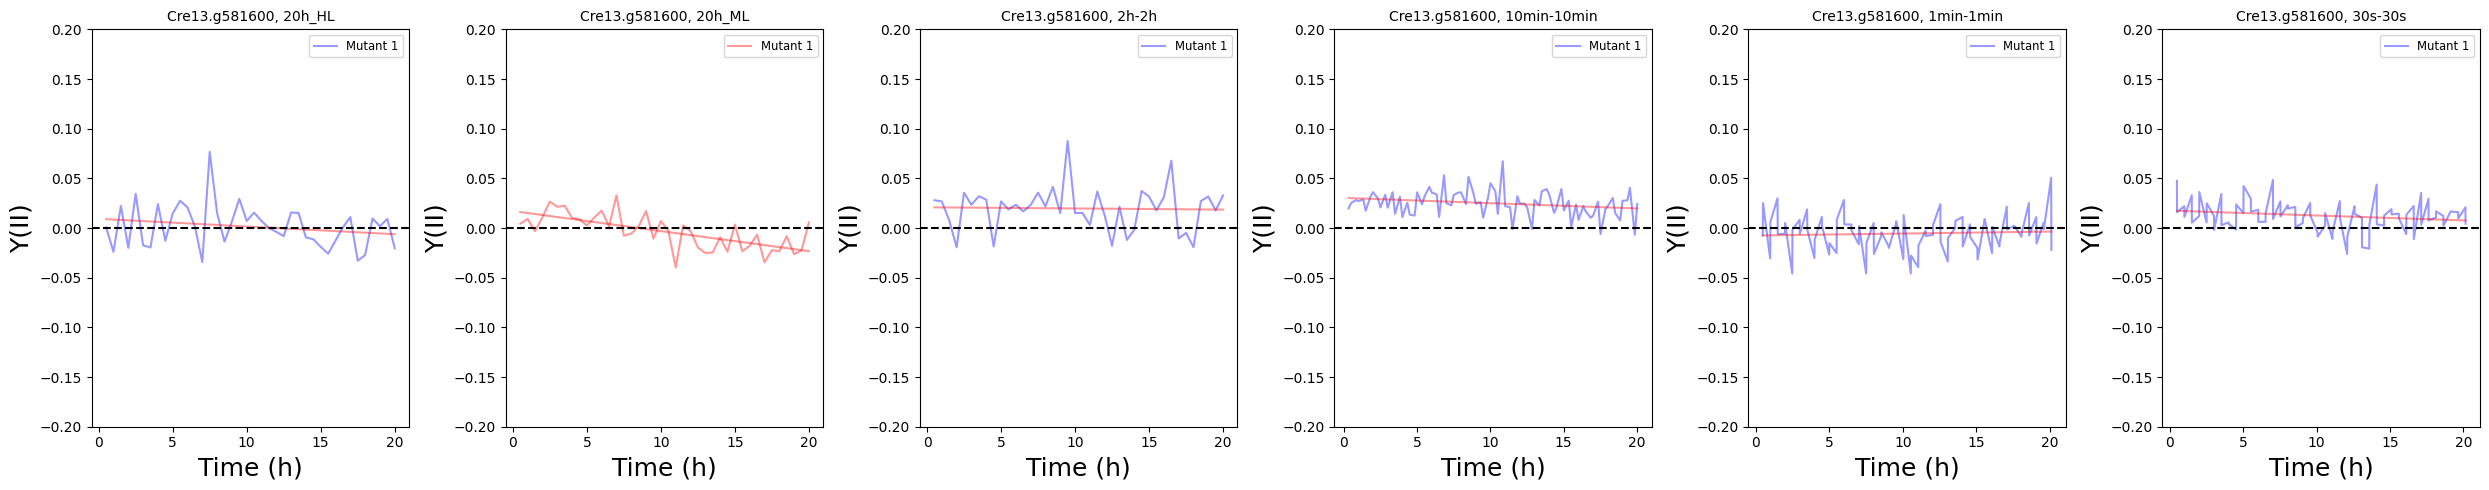

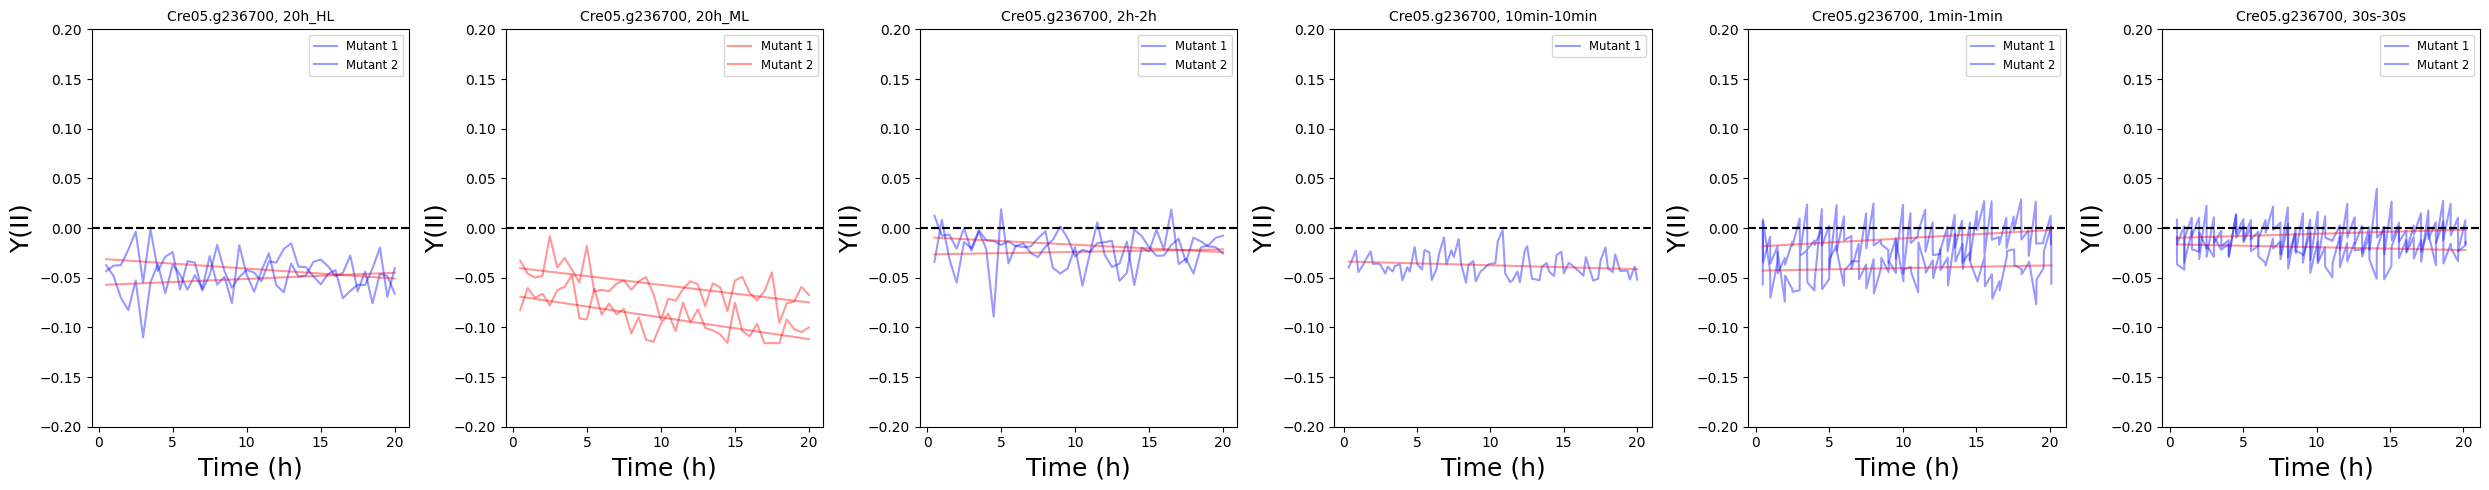

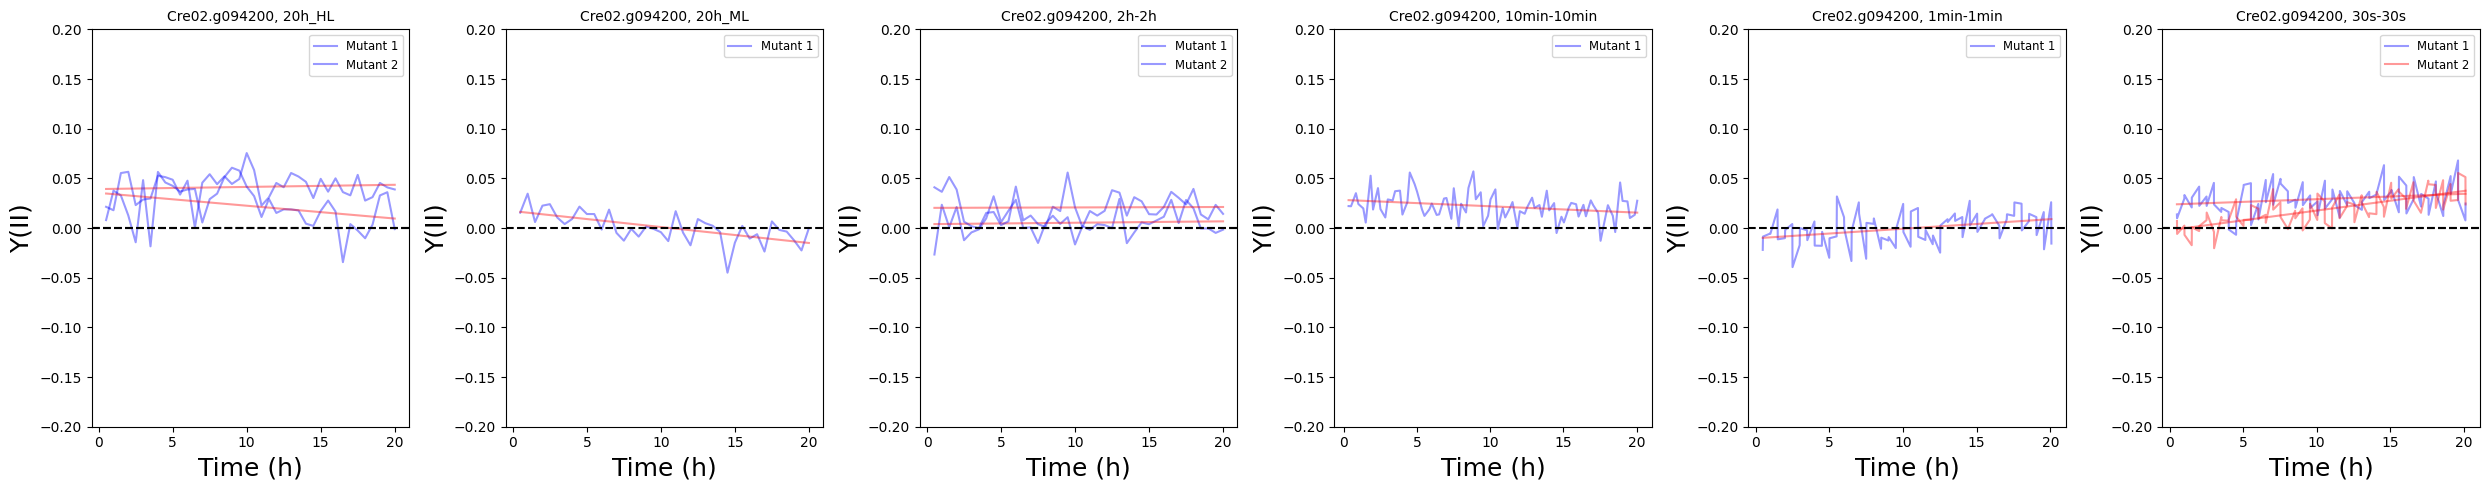

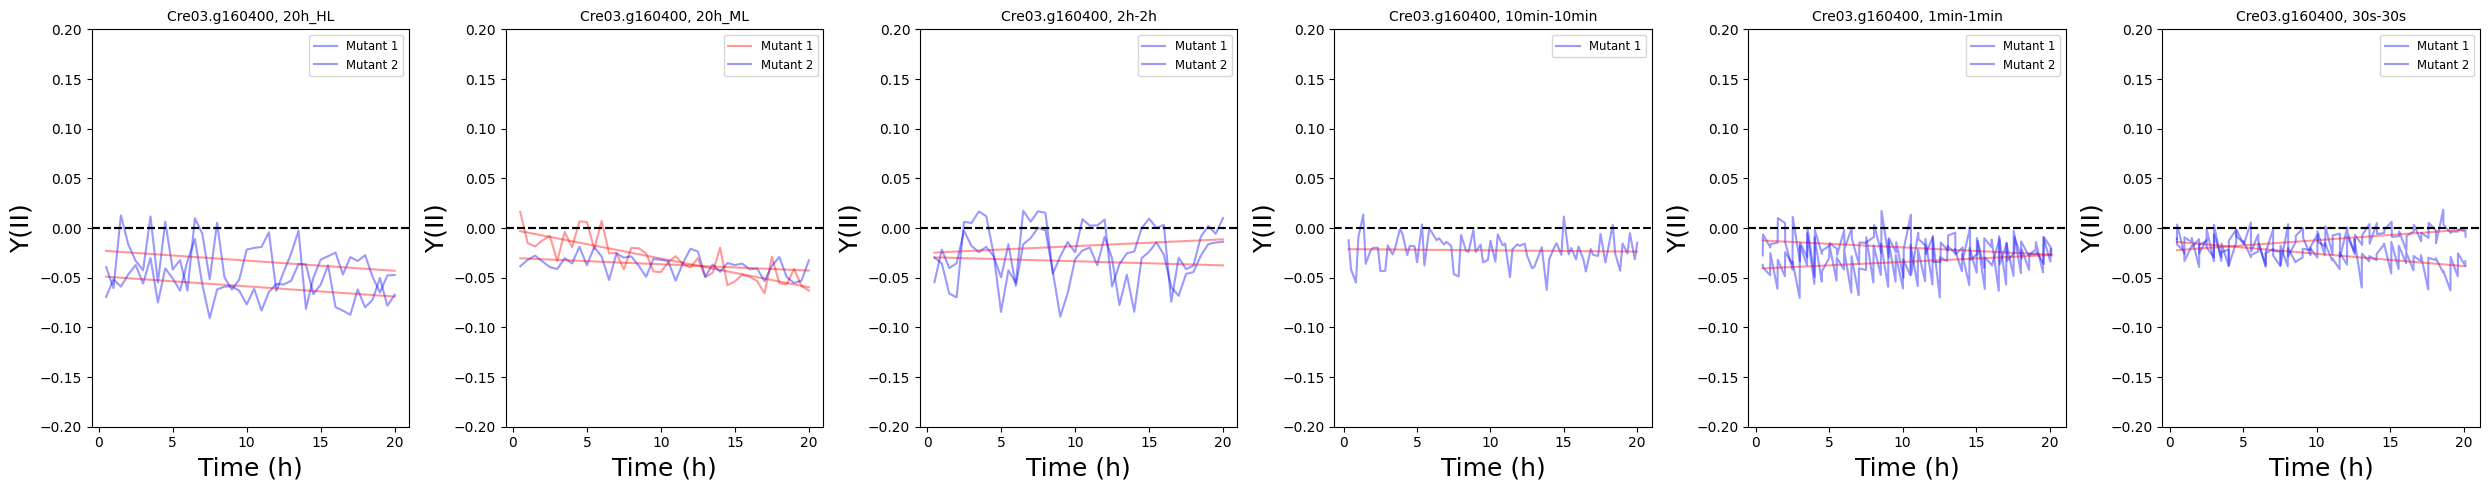

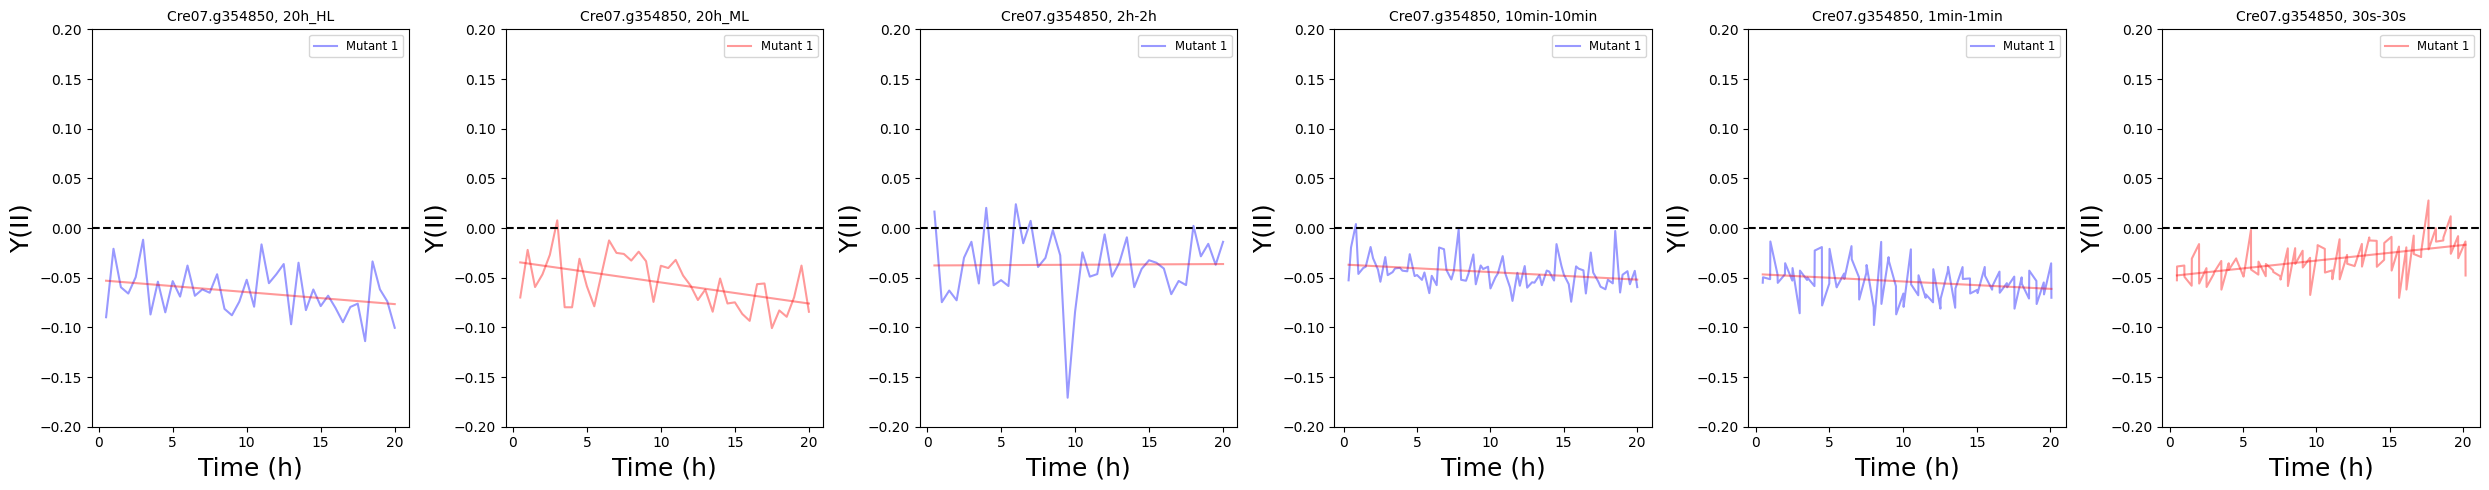

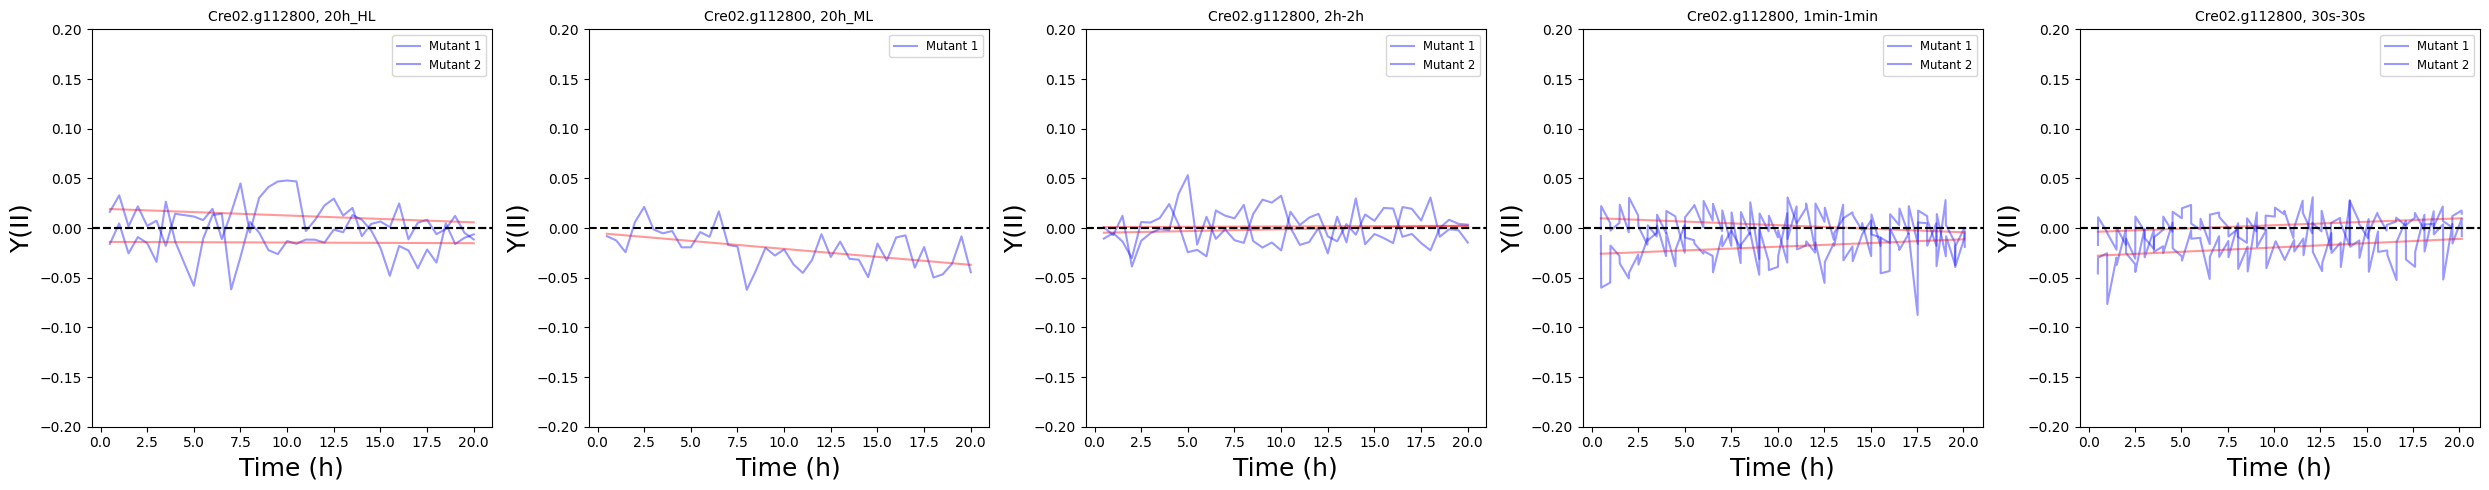

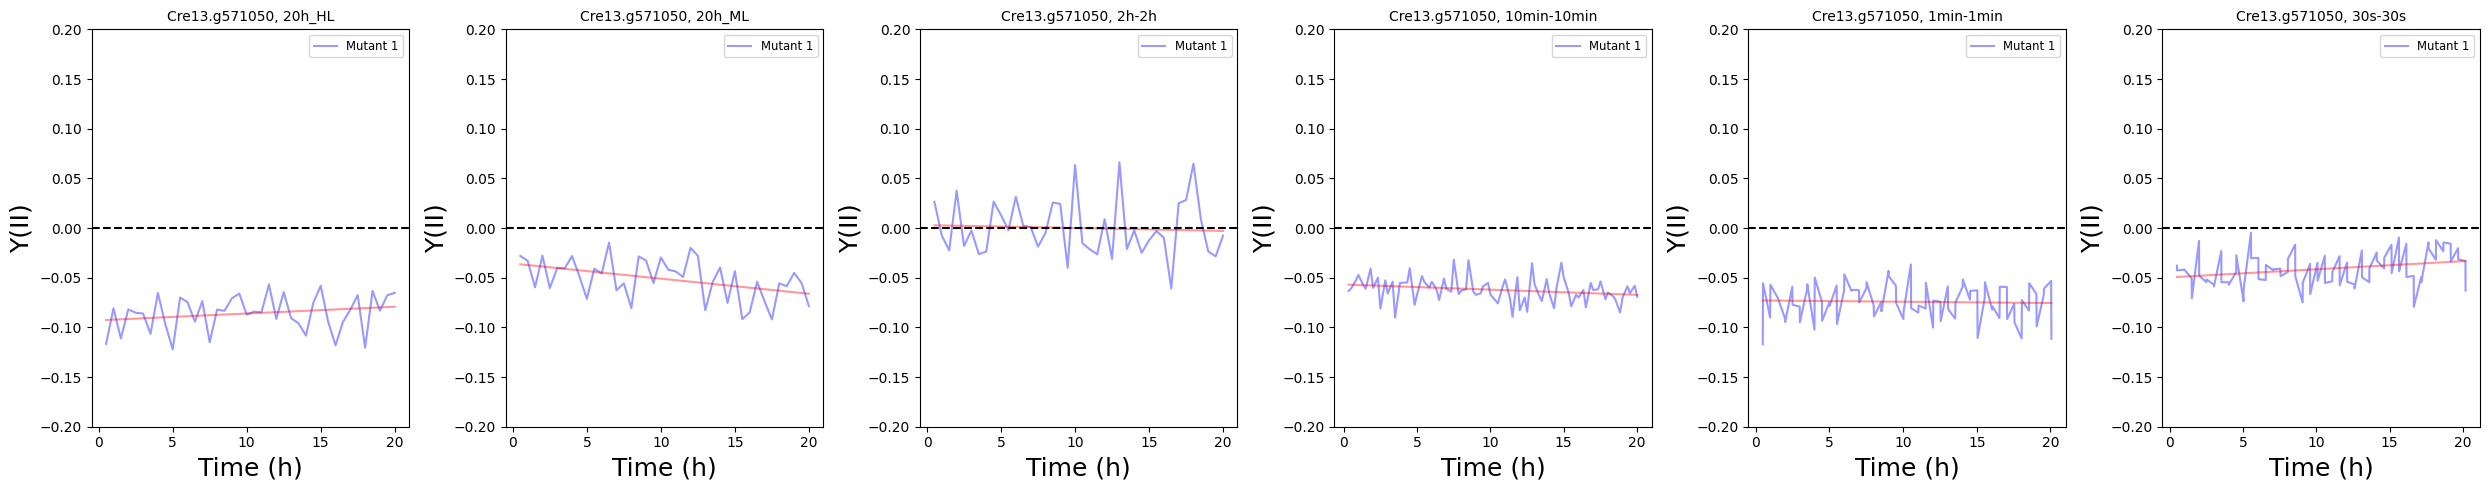

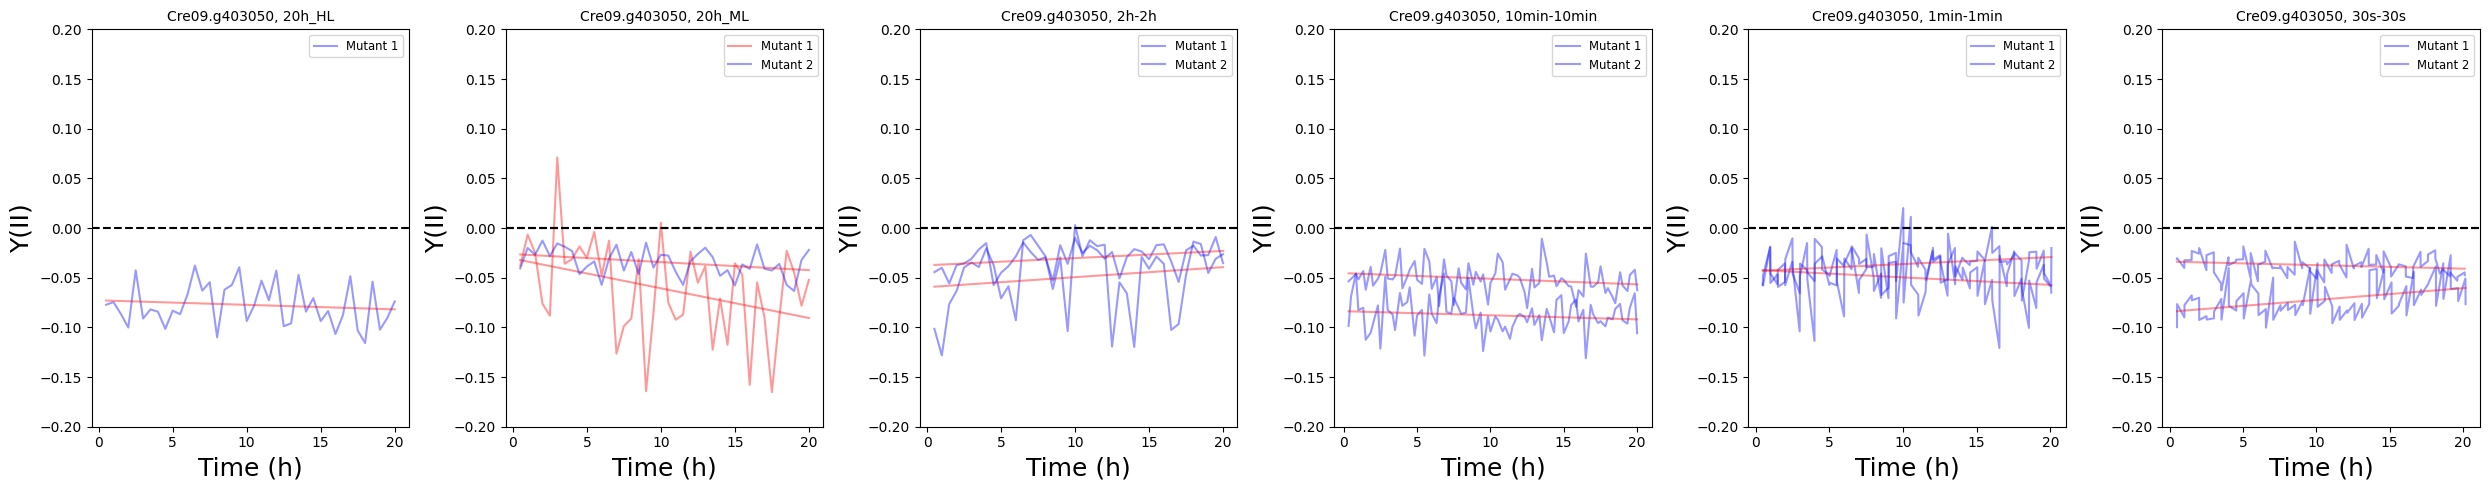

In [127]:
elapsed_time_columns = [col for col in data_slope_cluster.columns if 'elapsed_time' in col]
already_seen_genes = []

y = 'y2'

for i in range(10):
# # for i in range(10):
    gene_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == '20h_ML'].sort_values(by='confidence', ascending=False)['mutated_genes'].values[i]
    # mutant_of_interest = region_mutants_RTL['mutant_ID'].unique()[i]
#     # mutant_of_interest = result_residuals_slope['mutant_ID'].unique()[i+50]
#     # mutant_of_interest = mutant_data_with_pca.sort_values(by='slope_y2_1min-1min')['mutant_ID'].unique()[i]
#     mutant_of_interest = final_filtered_mutants.sort_values(by='slope_y2')['mutant_ID'].unique()[i]
#     # mutant_of_interest = final_filtered_mutants.sort_values(by='confidence')['mutant_ID'].unique()[i]
#     # mutant_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutant_ID'].unique()[i]

#     try:
#         gene_of_interest = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest)]['mutated_genes'].unique()[0]
#     except:
#         print('mutant_of_interest : ', mutant_of_interest)
    # # gene_of_interest = gene_diff[i]
    # if gene_of_interest in already_seen_genes or gene_of_interest == 'special_mutant':
    #     continue
    # if mutant_of_interest in already_seen_genes or mutant_of_interest == 'WT':
    #     continue
    already_seen_genes.append(gene_of_interest)
    # already_seen_genes.append(mutant_of_interest)
    # gene_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutated_genes'].unique()[i]

    # Sample array containing some of the values
    # light_regimes = data_slopes[(data_slopes['mutant_ID'] == mutant_of_interest)]['light_regime'].unique()
    light_regimes = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest)]['light_regime'].unique()

    # Sort the array using the custom sort key
    sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)
    # titles = ['Y(II) for gene ' + str(gene_of_interest) + ' in ' + light for light in sorted_light_regimes]
    titles = [str(gene_of_interest) + ', ' + light for light in sorted_light_regimes]
    # titles = ['Y(II) for gene ' + str(mutant_of_interest) + ' in ' + light for light in sorted_light_regimes]
    # colors = ['b', 'r', 'g', 'k', 'purple', 'grey']
    # colors = colors[:len(titles)]

    # Prepare subplot layout
    fig, axes = plt.subplots(1, len(titles), figsize=(25, 5))

    # Iterate over light regimes and plot Y(II) values
    for j, (light_regime, title) in enumerate(zip(sorted_light_regimes, titles)):
        # Filter data for the current gene and light regime
        # filtered_data = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest) & 
        #                                     (data_slope_cluster['light_regime'] == light_regime)]
        filtered_data = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest) & 
                                            (data_slope_cluster['light_regime'] == light_regime)]
        
        # print('light_regime :' , light_regime, 'fv_fm : ', filtered_data['fv_fm'].values)
        # Extract Y(II) values and plot each line
        y2_values = filtered_data.filter(regex=r'^'+y+'_\d+$').dropna(axis=1).values

        for k in range(y2_values.shape[0]):
            if light_regime in ['high_2h-2h', 'high_10min-10min', 'high_1min-1min', 'high_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:]
            elif light_regime in ['low_2h-2h', 'low_10min-10min', 'low_1min-1min', 'low_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][:-1]
            else:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:-1]
            if filtered_data['slope_cluster_' + y].values[k] != 0:
                color = 'r'
            else:
                color = 'b'
            # color = 'b'
            try :
                axes[j].plot(elapsed_time, y2_values[k], c=color, alpha=0.4, label='Mutant {}'.format(k+1))
                # plot the linear regression
                model = LinearRegression()
                model.fit(elapsed_time.reshape(-1, 1), y2_values[k])
                y_pred = model.predict(elapsed_time.reshape(-1, 1))
                axes[j].plot(elapsed_time, y_pred, c='r', alpha=0.4)
                axes[j].axhline(y=0, color='black', linestyle='--')
                # Set title and other plot properties
                axes[j].set_title(title, fontsize=10)
                # axes[j].set_title(light_regime)
                axes[j].set_xlabel('Time (h)', fontsize=18)
                axes[j].set_ylabel('Y(II)', fontsize=18)
                axes[j].set_ylim(-0.2, 0.2)
                axes[j].legend(loc='upper right', fontsize='small')
            except:
                continue

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [135]:
light_regime_to_int = {'20h_HL': 0, '20h_ML': 1, '2h-2h': 2, '10min-10min': 3, '1min-1min': 4, '30s-30s': 5}

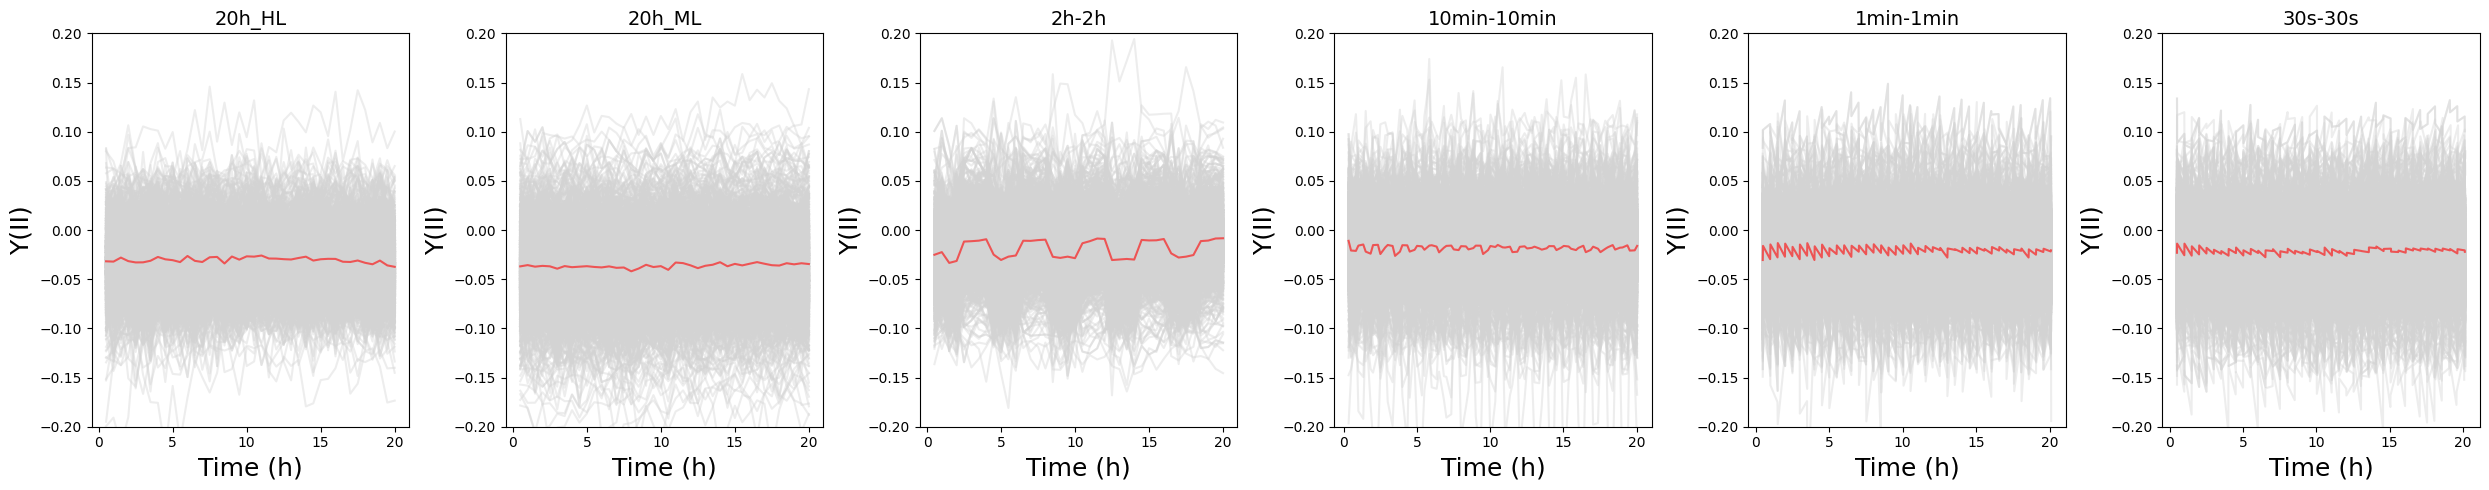

In [180]:
gene_type = 'WT'

# Assuming 6 subplots are meant to represent different light regimes
fig, axes = plt.subplots(1, 6, figsize=(25, 5))

already_seen_genes = []

# Loop through each gene of interest
for i in range(gene_pivot[gene_pivot['predicted_gene_type'] == gene_type].sort_values(by='confidence', ascending=False)['mutated_genes'].nunique()):
    gene_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == gene_type].sort_values(by='confidence', ascending=False)['mutated_genes'].values[i]
    already_seen_genes.append(gene_of_interest)
    light_regimes = data_slope_cluster[data_slope_cluster['mutated_genes'] == gene_of_interest]['light_regime'].unique()
    sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)

    # Plot each light regime for the gene
    for light_regime in sorted_light_regimes:
        j = light_regime_to_int[light_regime]
        filtered_data = gene_data[(gene_data['mutated_genes'] == gene_of_interest) & 
                                  (gene_data['light_regime'] == light_regime)]
        
        y2_values = filtered_data.filter(regex=r'^' + y + '_\d+$').dropna(axis=1).values[0]
        elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[0][1:-1]

        # Plotting on the rightmost subplot (axes[-1]) for all genes
        try:
            # Plot the individual gene with a lighter color
            axes[j].plot(elapsed_time, y2_values, c='lightgrey', alpha=0.4)

            # Set axis labels and limits
            axes[j].set_xlabel('Time (h)', fontsize=18)
            axes[j].set_ylabel('Y(II)', fontsize=18)
            axes[j].set_ylim(-0.2, 0.2)

        except Exception as e:
            print(f"Error plotting gene {gene_of_interest} for light regime {light_regime}: {e}")
            continue

genes_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == gene_type].sort_values(by='confidence', ascending=False)['mutated_genes'].unique()

# get the average of all the genes
gene_data_filtered = gene_data[gene_data['mutated_genes'].isin(genes_of_interest)]
gene_data_filtered = gene_data_filtered[['light_regime'] + y2_cols + ['slope_y2'] + elapsed_time_columns].groupby(['light_regime']).mean().reset_index()

# plot the average of all the genes on the same figure

for light_regime in gene_data_filtered['light_regime'].unique():
    j = light_regime_to_int[light_regime]
    filtered_data = gene_data_filtered[gene_data_filtered['light_regime'] == light_regime]
    y2_values = filtered_data[y2_cols].values[0]
    elapsed_time = filtered_data[elapsed_time_columns].values[0][1:-1]
    color = 'r'
    axes[j].plot(elapsed_time, y2_values, c=color, alpha=0.6, label='Average of all genes')
    axes[j].set_title(light_regime, fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [160]:
y2_cols = [col for col in gene_data.columns if col.startswith('y2_')]

In [161]:
genes_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == '20h_ML'].sort_values(by='confidence', ascending=False)['mutated_genes'].unique()

# get the average of all the genes
gene_data_filtered = gene_data[gene_data['mutated_genes'].isin(genes_of_interest)]
gene_data_filtered = gene_data_filtered[['light_regime'] + y2_cols + ['slope_y2'] + elapsed_time_columns].groupby(['light_regime']).mean().reset_index()

In [162]:
filtered_data = gene_data_filtered[gene_data_filtered['light_regime'] == light_regime]

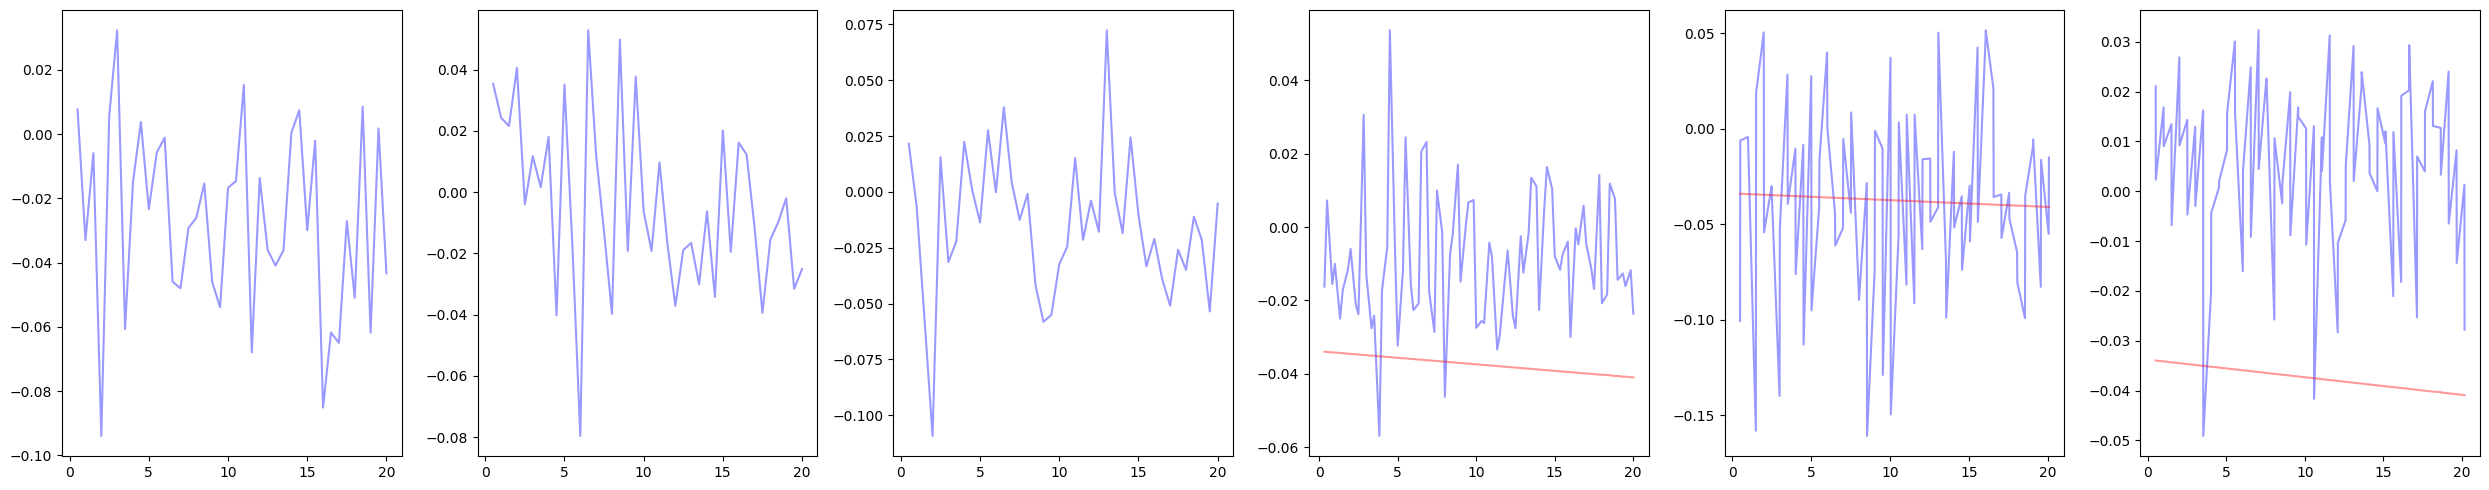

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [115]:
elapsed_time_columns = [col for col in data_slope_cluster.columns if 'elapsed_time' in col]
already_seen_genes = []

y = 'y2'

# Prepare subplot layout
fig, axes = plt.subplots(1, 6, figsize=(25, 5))

for i in range(10):
# # for i in range(10):
    gene_of_interest = gene_pivot[gene_pivot['predicted_gene_type'] == '20h_ML'].sort_values(by='confidence', ascending=False)['mutated_genes'].values[i]
    # mutant_of_interest = region_mutants_RTL['mutant_ID'].unique()[i]
#     # mutant_of_interest = result_residuals_slope['mutant_ID'].unique()[i+50]
#     # mutant_of_interest = mutant_data_with_pca.sort_values(by='slope_y2_1min-1min')['mutant_ID'].unique()[i]
#     mutant_of_interest = final_filtered_mutants.sort_values(by='slope_y2')['mutant_ID'].unique()[i]
#     # mutant_of_interest = final_filtered_mutants.sort_values(by='confidence')['mutant_ID'].unique()[i]
#     # mutant_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutant_ID'].unique()[i]

#     try:
#         gene_of_interest = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest)]['mutated_genes'].unique()[0]
#     except:
#         print('mutant_of_interest : ', mutant_of_interest)
    # # gene_of_interest = gene_diff[i]
    # if gene_of_interest in already_seen_genes or gene_of_interest == 'special_mutant':
    #     continue
    # if mutant_of_interest in already_seen_genes or mutant_of_interest == 'WT':
    #     continue
    already_seen_genes.append(gene_of_interest)
    # already_seen_genes.append(mutant_of_interest)
    # gene_of_interest = monotonic_mutants.sort_values(by='slope_y2_1min-1min', ascending=True)['mutated_genes'].unique()[i]

    light_regimes = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest)]['light_regime'].unique()

    # Sort the array using the custom sort key
    sorted_light_regimes = sorted(light_regimes, key=custom_sort_key)
    titles = [str(gene_of_interest) + ', ' + light for light in sorted_light_regimes]

    # Iterate over light regimes and plot Y(II) values
    for j, (light_regime, title) in enumerate(zip(sorted_light_regimes, titles)):
        # Filter data for the current gene and light regime
        # filtered_data = data_slope_cluster[(data_slope_cluster['mutant_ID'] == mutant_of_interest) & 
        #                                     (data_slope_cluster['light_regime'] == light_regime)]
        filtered_data = data_slope_cluster[(data_slope_cluster['mutated_genes'] == gene_of_interest) & 
                                            (data_slope_cluster['light_regime'] == light_regime)]
        
        # print('light_regime :' , light_regime, 'fv_fm : ', filtered_data['fv_fm'].values)
        # Extract Y(II) values and plot each line
        y2_values = filtered_data.filter(regex=r'^'+y+'_\d+$').dropna(axis=1).values

        for k in range(y2_values.shape[0]):
            if light_regime in ['high_2h-2h', 'high_10min-10min', 'high_1min-1min', 'high_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:]
            elif light_regime in ['low_2h-2h', 'low_10min-10min', 'low_1min-1min', 'low_30s-30s']:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][:-1]
            else:
                elapsed_time = filtered_data[elapsed_time_columns].dropna(axis=1).values[k][1:-1]
            color = 'b'
            # color = 'b'
            try :
                axes[j].plot(elapsed_time, y2_values[k], c=color, alpha=0.4, label='Mutant {}'.format(k+1))
                axes[j].plot(elapsed_time, y_pred, c='r', alpha=0.4)
            except:
                continue

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()